In [1]:
import torch
import numpy as np
import datasets
import os
import pandas as pd
import random
#import umap
import sys
import evaluate
import json
import seaborn as sns
import re
import nltk
from pathlib import Path
from itertools import product
from IPython.core.debugger import set_trace
from datasets import Dataset, DatasetDict, concatenate_datasets
from torch import nn
from sentence_transformers import SentenceTransformer
from sentence_transformers.models import Transformer, Pooling
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from IPython.core.debugger import Pdb, set_trace
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import util
#from tqdm.notebook import tqdm
from tqdm import tqdm
from numpy.lib.stride_tricks import sliding_window_view
from pprint import pprint
from scipy.cluster.hierarchy import linkage

from nbtools.utils import files, strings
from nbtools.sent_encoders import from_hf

datasets.disable_caching()

cache_dir = '/data/john/cache'
proot = files.project_root()

# Set this to whatever you want
seed = 10

torch.manual_seed(seed)
np.random.seed(seed)

%load_ext autoreload
%autoreload 2
%matplotlib inline

/data/john/projects/nb/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-09 17:34:20.639672: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 17:34:22.752321: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [33]:
# read the main dataset
ds = Dataset.from_json('/data/john/projects/llm_eval/data/results/20240502-185939/all_scores.json')
print(ds)

Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id'],
    num_rows: 961792
})


In [34]:
os.chdir('/data/john/projects/llm_eval/data/results/20240502-185939-rouge')
os.listdir()

['lmsys',
 'checkpoint.json',
 'eval_progress.json',
 'gpt-3.5-turbo',
 'meta-llama',
 'gemini-pro',
 'eval_progress.json.bak',
 'progress.json',
 'microsoft',
 'progress.json.bak',
 'mistralai',
 'mosaicml']

In [8]:
# get file names in target path
base_path = './'
targets = []
for path, subdirs, fnames in os.walk(base_path):
    for name in fnames:
        if name.endswith('scores.json'):
            targets.append(os.path.join(path, name))
targets = sorted(targets)
target_groups = list(zip(
    [targets[i] for i in range(0, len(targets), 2)],
    [targets[i] for i in range(1, len(targets), 2)]
))
pprint(target_groups)

[('./gemini-pro/all_sides-scores.json',
  './gemini-pro/privacy_policy-scores.json'),
 ('./gpt-3.5-turbo/all_sides-scores.json',
  './gpt-3.5-turbo/privacy_policy-scores.json'),
 ('./lmsys/vicuna-13b-v1.5-16k/all_sides-scores.json',
  './lmsys/vicuna-13b-v1.5-16k/privacy_policy-scores.json'),
 ('./lmsys/vicuna-13b-v1.5/all_sides-scores.json',
  './lmsys/vicuna-13b-v1.5/privacy_policy-scores.json'),
 ('./lmsys/vicuna-7b-v1.5-16k/all_sides-scores.json',
  './lmsys/vicuna-7b-v1.5-16k/privacy_policy-scores.json'),
 ('./lmsys/vicuna-7b-v1.5/all_sides-scores.json',
  './lmsys/vicuna-7b-v1.5/privacy_policy-scores.json'),
 ('./meta-llama/Llama-2-13b-chat-hf/all_sides-scores.json',
  './meta-llama/Llama-2-13b-chat-hf/privacy_policy-scores.json'),
 ('./meta-llama/Llama-2-7b-chat-hf/all_sides-scores.json',
  './meta-llama/Llama-2-7b-chat-hf/privacy_policy-scores.json'),
 ('./meta-llama/Meta-Llama-3-8B-Instruct/all_sides-scores.json',
  './meta-llama/Meta-Llama-3-8B-Instruct/privacy_policy-scores.

In [10]:
model_names = [re.match(r'\./(.*)/.*', trgt).groups()[0] for trgt in targets]
model_names = [model_names[i] for i in range(0, len(model_names), 2)]
print(model_names)

['gemini-pro', 'gpt-3.5-turbo', 'lmsys/vicuna-13b-v1.5-16k', 'lmsys/vicuna-13b-v1.5', 'lmsys/vicuna-7b-v1.5-16k', 'lmsys/vicuna-7b-v1.5', 'meta-llama/Llama-2-13b-chat-hf', 'meta-llama/Llama-2-7b-chat-hf', 'meta-llama/Meta-Llama-3-8B-Instruct', 'microsoft/Phi-3-mini-128k-instruct', 'microsoft/Phi-3-mini-4k-instruct', 'mistralai/Mistral-7B-Instruct-v0.1', 'mistralai/Mistral-7B-Instruct-v0.2', 'mosaicml/mpt-30b-chat', 'mosaicml/mpt-30b-instruct', 'mosaicml/mpt-7b-chat', 'mosaicml/mpt-7b-instruct']


In [30]:
dsets = []
for as_path, pp_path in target_groups:

    # check if model names are the same
    m_name1 = re.match(r'\./(.*)/.*', as_path).groups()[0]
    m_name2 = re.match(r'\./(.*)/.*', pp_path).groups()[0]
    assert m_name1 == m_name2

    # set model name
    model_name = m_name1

    res_path = as_path.replace('all_sides-scores', 'results')
    print(res_path)

    # read in datasets
    res_data = Dataset.from_json(res_path)
    as_data = Dataset.from_json(as_path)
    pp_data = Dataset.from_json(pp_path)

    # get originally ignored samples
    ig_data = res_data.filter(
        lambda x: x['response'] == None or x['response'].strip() == ''
    )

    # add missing columns
    cols = set(as_data.features.keys()) - set(ig_data.features.keys())
    cols.remove('index')

    for col in cols:
        ig_data = ig_data.add_column(col, [0.0]*len(ig_data))

    model_data = concatenate_datasets([
        as_data, pp_data, ig_data,
    ])
    model_data = model_data.add_column('model', [model_name]*len(model_data))
    dsets.append(model_data)
rouge_data = concatenate_datasets(dsets)
print(rouge_data)

./gemini-pro/results.json


Filter:   0%|          | 0/56576 [00:00<?, ? examples/s]

Filter: 100%|██████████| 56576/56576 [00:00<00:00, 172476.36 examples/s]


./gpt-3.5-turbo/results.json


Flattening the indices: 100%|██████████| 3/3 [00:00<00:00, 1398.41 examples/s]


./lmsys/vicuna-13b-v1.5-16k/results.json


Flattening the indices: 100%|██████████| 23/23 [00:00<00:00, 8731.02 examples/s]


./lmsys/vicuna-13b-v1.5/results.json


Flattening the indices: 100%|██████████| 20/20 [00:00<00:00, 7556.62 examples/s]


./lmsys/vicuna-7b-v1.5-16k/results.json


Flattening the indices: 100%|██████████| 43/43 [00:00<00:00, 14751.76 examples/s]


./lmsys/vicuna-7b-v1.5/results.json


Flattening the indices: 100%|██████████| 19/19 [00:00<00:00, 7453.40 examples/s]


./meta-llama/Llama-2-13b-chat-hf/results.json


Filter: 100%|██████████| 56576/56576 [00:00<00:00, 170060.47 examples/s]


./meta-llama/Llama-2-7b-chat-hf/results.json


Filter: 100%|██████████| 56576/56576 [00:00<00:00, 170383.93 examples/s]


./meta-llama/Meta-Llama-3-8B-Instruct/results.json


Filter: 100%|██████████| 56576/56576 [00:00<00:00, 151499.66 examples/s]


./microsoft/Phi-3-mini-128k-instruct/results.json


Filter: 100%|██████████| 56576/56576 [00:00<00:00, 177424.51 examples/s]


./microsoft/Phi-3-mini-4k-instruct/results.json


Filter: 100%|██████████| 56576/56576 [00:00<00:00, 173064.30 examples/s]


./mistralai/Mistral-7B-Instruct-v0.1/results.json


Filter: 100%|██████████| 56576/56576 [00:00<00:00, 175730.47 examples/s]


./mistralai/Mistral-7B-Instruct-v0.2/results.json


Flattening the indices: 100%|██████████| 26/26 [00:00<00:00, 11160.77 examples/s]


./mosaicml/mpt-30b-chat/results.json


Flattening the indices: 100%|██████████| 300/300 [00:00<00:00, 31342.10 examples/s]


./mosaicml/mpt-30b-instruct/results.json


Flattening the indices: 100%|██████████| 299/299 [00:00<00:00, 30623.58 examples/s]


./mosaicml/mpt-7b-chat/results.json


Flattening the indices: 100%|██████████| 359/359 [00:00<00:00, 34698.02 examples/s]


./mosaicml/mpt-7b-instruct/results.json


Flattening the indices: 100%|██████████| 292/292 [00:00<00:00, 32324.34 examples/s]


Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'model'],
    num_rows: 961792
})


In [32]:
for i, (s1, s2) in tqdm(enumerate(zip(rouge_data, ds)), total=len(rouge_data)):


    idres = s1["id"] == s2["id"]
    dsres = s1["dataset"] == s2["dataset"]
    mres = s1["model"] == s2["model"]
    pres = s1["prompt"] == s2["prompt"]
    if not all([idres, dsres, mres]):
        print(i)
print(i)

  0%|          | 0/961792 [00:00<?, ?it/s]

100%|██████████| 961792/961792 [02:26<00:00, 6559.06it/s]

961791


In [40]:
cols = set(ds.features.keys())
rouge_cols = {col for col in cols if 'rouge' in col}

fixed_data = ds.remove_columns(rouge_cols)
for col in rouge_cols:
    fixed_data = fixed_data.add_column(col, rouge_data[col])

0.26028275207559626


In [3]:
#fixed_data.to_json('/data/john/projects/llm_eval/data/results/20240502-185939/all_scores_fixed.json')
ds = 

NameError: name 'fixed_data' is not defined

In [44]:
print(ds)

Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2'],
    num_rows: 961792
})


In [51]:
ds = Dataset.from_json(
    '/data/john/projects/llm_eval/data/results/20240502-185939/'
    'all_scores_fixed.json'
)
metrics = [
    'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 
    'rougeLsum', 'rougeL', 'rouge1', 'rouge2'
]
model_names = set(ds['model'])
ref_data = set(ds['dataset'])
templates = set(ds['template'])

best_prompts = {ds_name: {} for ds_name in ref_data}
#best_prompts[ds_name] = {}
for ds_name, tmplt in tqdm(
        product(ref_data, templates),
        total=len(ref_data)*len(templates)):

    ref_ds = ds.filter(
        lambda x: x['dataset'] == ds_name and x['template'] == tmplt
    )
    sys_ids = set(ref_ds['sys_text_id'])
    prompt_ids = set(ref_ds['prompt_text_id'])
    candidates = []
    mean_scores = []
    for sid, pid in product(sys_ids, prompt_ids):
        tmplt_ds = ref_ds.filter(
            lambda x: x['sys_text_id'] == sid 
                and x['prompt_text_id'] == pid
        )
        candidates.append((sid, pid))
        mean = np.mean([np.mean(tmplt_ds[met]) for met in metrics])
        mean_scores.append(mean)
    best = np.argmax(np.array(mean_scores))
    best_prompts[ds_name][tmplt] = dict(zip(
        ['sid', 'pid'], candidates[best]
    ))

print(best_prompts)


100%|██████████| 12/12 [32:19<00:00, 161.66s/it]

{'privacy_policy': {'l1': {'sid': 7, 'pid': 5}, 'l0': {'sid': 7, 'pid': 0}, 'l2': {'sid': 7, 'pid': 1}, 'l4': {'sid': 7, 'pid': 1}, 'l3': {'sid': 7, 'pid': 4}, 'icl': {'sid': 0, 'pid': 0}}, 'all_sides': {'l1': {'sid': 1, 'pid': 4}, 'l0': {'sid': 0, 'pid': 0}, 'l2': {'sid': 6, 'pid': 1}, 'l4': {'sid': 7, 'pid': 1}, 'l3': {'sid': 6, 'pid': 4}, 'icl': {'sid': 0, 'pid': 0}}}


In [35]:
pprint(best_prompts)

{'all_sides': {'icl': {'pid': 0, 'sid': 0},
               'l0': {'pid': 0, 'sid': 0},
               'l1': {'pid': 4, 'sid': 1},
               'l2': {'pid': 1, 'sid': 6},
               'l3': {'pid': 4, 'sid': 6},
               'l4': {'pid': 1, 'sid': 7}},
 'privacy_policy': {'icl': {'pid': 0, 'sid': 0},
                    'l0': {'pid': 0, 'sid': 7},
                    'l1': {'pid': 5, 'sid': 7},
                    'l2': {'pid': 1, 'sid': 7},
                    'l3': {'pid': 4, 'sid': 7},
                    'l4': {'pid': 1, 'sid': 7}}}


In [26]:
best_prompts = {'all_sides': {'icl': {'pid': 0, 'sid': 0},
               'l0': {'pid': 0, 'sid': 0},
               'l1': {'pid': 4, 'sid': 1},
               'l2': {'pid': 1, 'sid': 6},
               'l3': {'pid': 4, 'sid': 6},
               'l4': {'pid': 1, 'sid': 7}},
 'privacy_policy': {'icl': {'pid': 0, 'sid': 0},
                    'l0': {'pid': 0, 'sid': 7},
                    'l1': {'pid': 5, 'sid': 7},
                    'l2': {'pid': 1, 'sid': 7},
                    'l3': {'pid': 4, 'sid': 7},
                    'l4': {'pid': 1, 'sid': 7}}}

In [2]:
ds = Dataset.from_json(
    '/data/john/projects/llm_eval/data/results/20240502-185939/'
    'all_scores_fixed.json'
)
print(ds)

Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2'],
    num_rows: 961792
})


In [95]:
961792-56576

905216

In [104]:
len(ds.filter(lambda x: x['id'] == 1 and x['dataset'] == 'all_sides')

Filter:   0%|          | 0/961792 [00:00<?, ? examples/s]

Filter: 100%|██████████| 961792/961792 [00:17<00:00, 54818.44 examples/s]


3536

In [118]:
3536-(208*11)
208/6


34.666666666666664

# Build the Annotation Dataset

# Hardcode the Selected Samples

In [16]:
num_samples = 10
as_ids = set()
while len(as_ids) < num_samples:
    as_ids.add(random.randint(0, 136))

pp_ids = set()
while len(pp_ids) < num_samples:
    pp_ids.add(random.randint(0, 134))

sample_ids = {
    'all_sides': np.array(list(as_ids)),
    'privacy_policy': np.array(list(pp_ids)),
}
"""
sample_ids = {
    'all_sides': np.array([133,  16,  27,  92,  30]), 
    'privacy_policy': np.array([  3, 104, 111,  83,  53])
}
"""
sample_ids = {
    'all_sides': np.array([ 97,  98, 133,   7,   8,  44,  51,  21,  87,  90]), 
    'privacy_policy': np.array([  1, 134, 103, 113,  29,  20,  22, 122,  91, 125]),
}


print(sample_ids)


{'all_sides': array([ 97,  98, 133,   7,   8,  44,  51,  21,  87,  90]), 'privacy_policy': array([  1, 134, 103, 113,  29,  20,  22, 122,  91, 125])}


In [17]:
#models = sorted(set(ds['model']))
models = {
    'gemini-pro',
    'gpt-3.5-turbo',
    'lmsys/vicuna-13b-v1.5-16k',
    'meta-llama/Meta-Llama-3-8B-Instruct',
    'microsoft/Phi-3-mini-128k-instruct',
    'mistralai/Mistral-7B-Instruct-v0.2',
    'mosaicml/mpt-30b-chat',
}
pprint(models)

{'gemini-pro',
 'gpt-3.5-turbo',
 'lmsys/vicuna-13b-v1.5-16k',
 'meta-llama/Meta-Llama-3-8B-Instruct',
 'microsoft/Phi-3-mini-128k-instruct',
 'mistralai/Mistral-7B-Instruct-v0.2',
 'mosaicml/mpt-30b-chat'}


In [20]:
num_samples = 5

best_prompts = {'all_sides': {'icl': {'pid': 0, 'sid': 0},
               'l0': {'pid': 0, 'sid': 0},
               'l1': {'pid': 4, 'sid': 1},
               'l2': {'pid': 1, 'sid': 6},
               'l3': {'pid': 4, 'sid': 6},
               'l4': {'pid': 1, 'sid': 7}},
 'privacy_policy': {'icl': {'pid': 0, 'sid': 0},
                    'l0': {'pid': 0, 'sid': 7},
                    'l1': {'pid': 5, 'sid': 7},
                    'l2': {'pid': 1, 'sid': 7},
                    'l3': {'pid': 4, 'sid': 7},
                    'l4': {'pid': 1, 'sid': 7}}}

#models = sorted(set(ds['model']))
selected_samples = []
for ds_name, cats in best_prompts.items():
    for tmplt, ids in cats.items():
        sid, pid = ids['sid'], ids['pid']
        for model in models:
            sample_ds = ds.filter(
                lambda x: x['sys_text_id'] == sid 
                    and x['prompt_text_id'] == pid
                    and x['dataset'] == ds_name
                    and x['model'] == model
                    and x['template'] == tmplt
                    and x['id'] in sample_ids[x['dataset']],
                num_proc=8
            )
            """
            print(sample_ds)
            print(sample_ds['id'])
            set_trace()
            sample_indices = []
            while len(sample_indices) < num_samples:
                idx = random.randint(0, len(sample_ds)-1)
                if idx not in sample_indices:
                    sample_indices.append(idx)
            sample_indices = np.array(sample_indices)
            """
            #selected_samples.append(sample_ds.select(sample_indices))
            selected_samples.append(sample_ds)

print(selected_samples)


Filter (num_proc=8): 100%|██████████| 961792/961792 [00:01<00:00, 567316.02 examples/s]


[Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id'],
    num_rows: 10
}), Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id'],
    num_rows: 10
}), Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id'],
    num_rows: 10
}), Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore',

In [21]:
sampled_data = concatenate_datasets(selected_samples)

print(sampled_data)
print(len(set(sampled_data['index'])))
print(len(set(sampled_data['id'])))

Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id'],
    num_rows: 840
})
120
20


In [3]:
ref_data = {
    'all_sides': Dataset.from_json('/data/john/projects/llm_eval/data/all_sides/test.json'),
    'privacy_policy': Dataset.from_csv('/data/john/projects/llm_eval/data/privacy_policy/3p_data.csv')
}
doc_cols = {
    'all_sides': ['Left', 'Right'],
    'privacy_policy': ['Company_1', 'Company_2'],
}
print(ref_data)

{'all_sides': Dataset({
    features: ['Key', 'Left', 'Right', 'Ahmed_Intersection', 'Naman_Intersection', 'Helen_Intersection', 'AllSides_Intersection'],
    num_rows: 137
}), 'privacy_policy': Dataset({
    features: ['Company_1', 'Company_2', 'Category', 'Company_Name_1', 'Company_Name_2', 'Company_Len_1', 'Company_Len_2', 'Annotator1', 'Annotator2', 'Annotator3', 'Unnamed: 10'],
    num_rows: 135
})}


# Count Avg Tokens In Each Dataset

In [23]:
ds_names = ['all_sides', 'privacy_policy']
avg_overlap = {}
overlap = {
    'all_sides': [],
    'privacy_policy': [],
}
total_tokens = {
    'all_sides': [],
    'privacy_policy': [],
}
for name in ds_names:
    d1, d2 = doc_cols[name]
    for sample in ref_data[name]:
        t1 = set(word_tokenize(sample[d1]))
        t2 = set(word_tokenize(sample[d2]))
        total_tokens[name] += [len(t1), len(t2)]
        tokens = set(t1).intersection(set(t2))
        tokens = tokens - set(stopwords.words('english'))
        overlap[name].append(len(tokens))
for name in ds_names:
    avg_overlap[name] = np.mean(overlap[name])
print(avg_overlap)
print(np.mean(total_tokens['all_sides']))
print(np.mean(total_tokens['privacy_policy']))
print(
    f'3P: {avg_overlap["privacy_policy"]/np.mean(total_tokens["privacy_policy"])}\n'
    f'AS: {avg_overlap["all_sides"]/np.mean(total_tokens["all_sides"])}'
)

{'all_sides': 38.481751824817515, 'privacy_policy': 30.57037037037037}
164.72992700729927
170.3074074074074
3P: 0.17950111997912271
AS: 0.2336051045728465


# Add Source Documents to Selected Data

In [24]:
d1 = [ref_data[x['dataset']][x['id']][doc_cols[x['dataset']][0]] for x in sampled_data]
d2 = [ref_data[x['dataset']][x['id']][doc_cols[x['dataset']][1]] for x in sampled_data]

sampled_data = sampled_data.add_column('doc1', d1)
sampled_data = sampled_data.add_column('doc2', d2)
print(sampled_data)


Flattening the indices: 100%|██████████| 840/840 [00:00<00:00, 5040.37 examples/s]


Dataset({
    features: ['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'rouge1', 'rouge2', 'rougeL', 'rougeLsum', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'doc1', 'doc2'],
    num_rows: 840
})


In [19]:
#sampled_data = sampled_data.shuffle()
#sampled_data = sampled_data.rename_columns({'ref1': 'doc1', 'ref2': 'doc2'})
fprefix = '/data/john/projects/llm_eval/data/results/20240502-185939/sampled_data'
sampled_data.to_json(fprefix + '.json')
with pd.ExcelWriter(fprefix + '.xlsx') as writer:
    sampled_data.to_pandas().to_excel(writer)

Creating json from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 22.50ba/s]

In [20]:
#sampled_data.select_columns([])
print(sampled_data.features.keys())
#sampled_data.select_columns(['index', 'doc1', 'doc2', 'response']).to_csv('/data/john/projects/llm_eval/data/results/20240502-185939/annotation_samples.csv')
fname = '/data/john/projects/llm_eval/data/results/20240502-185939/annotation_samples.xlsx'

annotation_data = sampled_data.shuffle().select_columns(['index', 'doc1', 'doc2', 'response'])
with pd.ExcelWriter(fname) as writer:
    annotation_data.to_pandas().to_excel(writer)

dict_keys(['id', 'template', 'dataset', 'system', 'prompt', 'response', 'index', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2', 'doc1', 'doc2'])


In [47]:
#annotation_data = Dataset.from_csv('/data/john/projects/llm_eval/data/results/20240502-185939/annotation_samples.csv')
annotation_data = Dataset.from_pandas(pd.read_excel('/data/john/projects/llm_eval/data/results/20240502-185939/annotation_samples_alt.xlsx'))
print(annotation_data)

Dataset({
    features: ['Unnamed: 0', 'index', 'doc1', 'doc2', 'response'],
    num_rows: 420
})


# End Annotation Set Building

In [4]:
fname = (
    '/data/john/projects/llm_eval/data/results/20240502-185939/'
    'annotation_samples_complete.xlsx'
)
human_scores = Dataset.from_pandas(pd.read_excel(fname))
print(human_scores)

Dataset({
    features: ['Column1', 'doc1', 'doc2', 'response', 'id', 'template', 'dataset', 'system', 'prompt', 'index', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2', 'annotator_1', 'annotator_2', 'annotator_3', 'annotator_agreement'],
    num_rows: 630
})


In [4]:
print(human_scores[498]['Column1'])

787


# Create Agreement Matrix for Automatic Evaluation Scores and Annotator Scores

Text(0.5, 1.0, "Kendall's $\\tau$ - Annotators vs. Metrics")

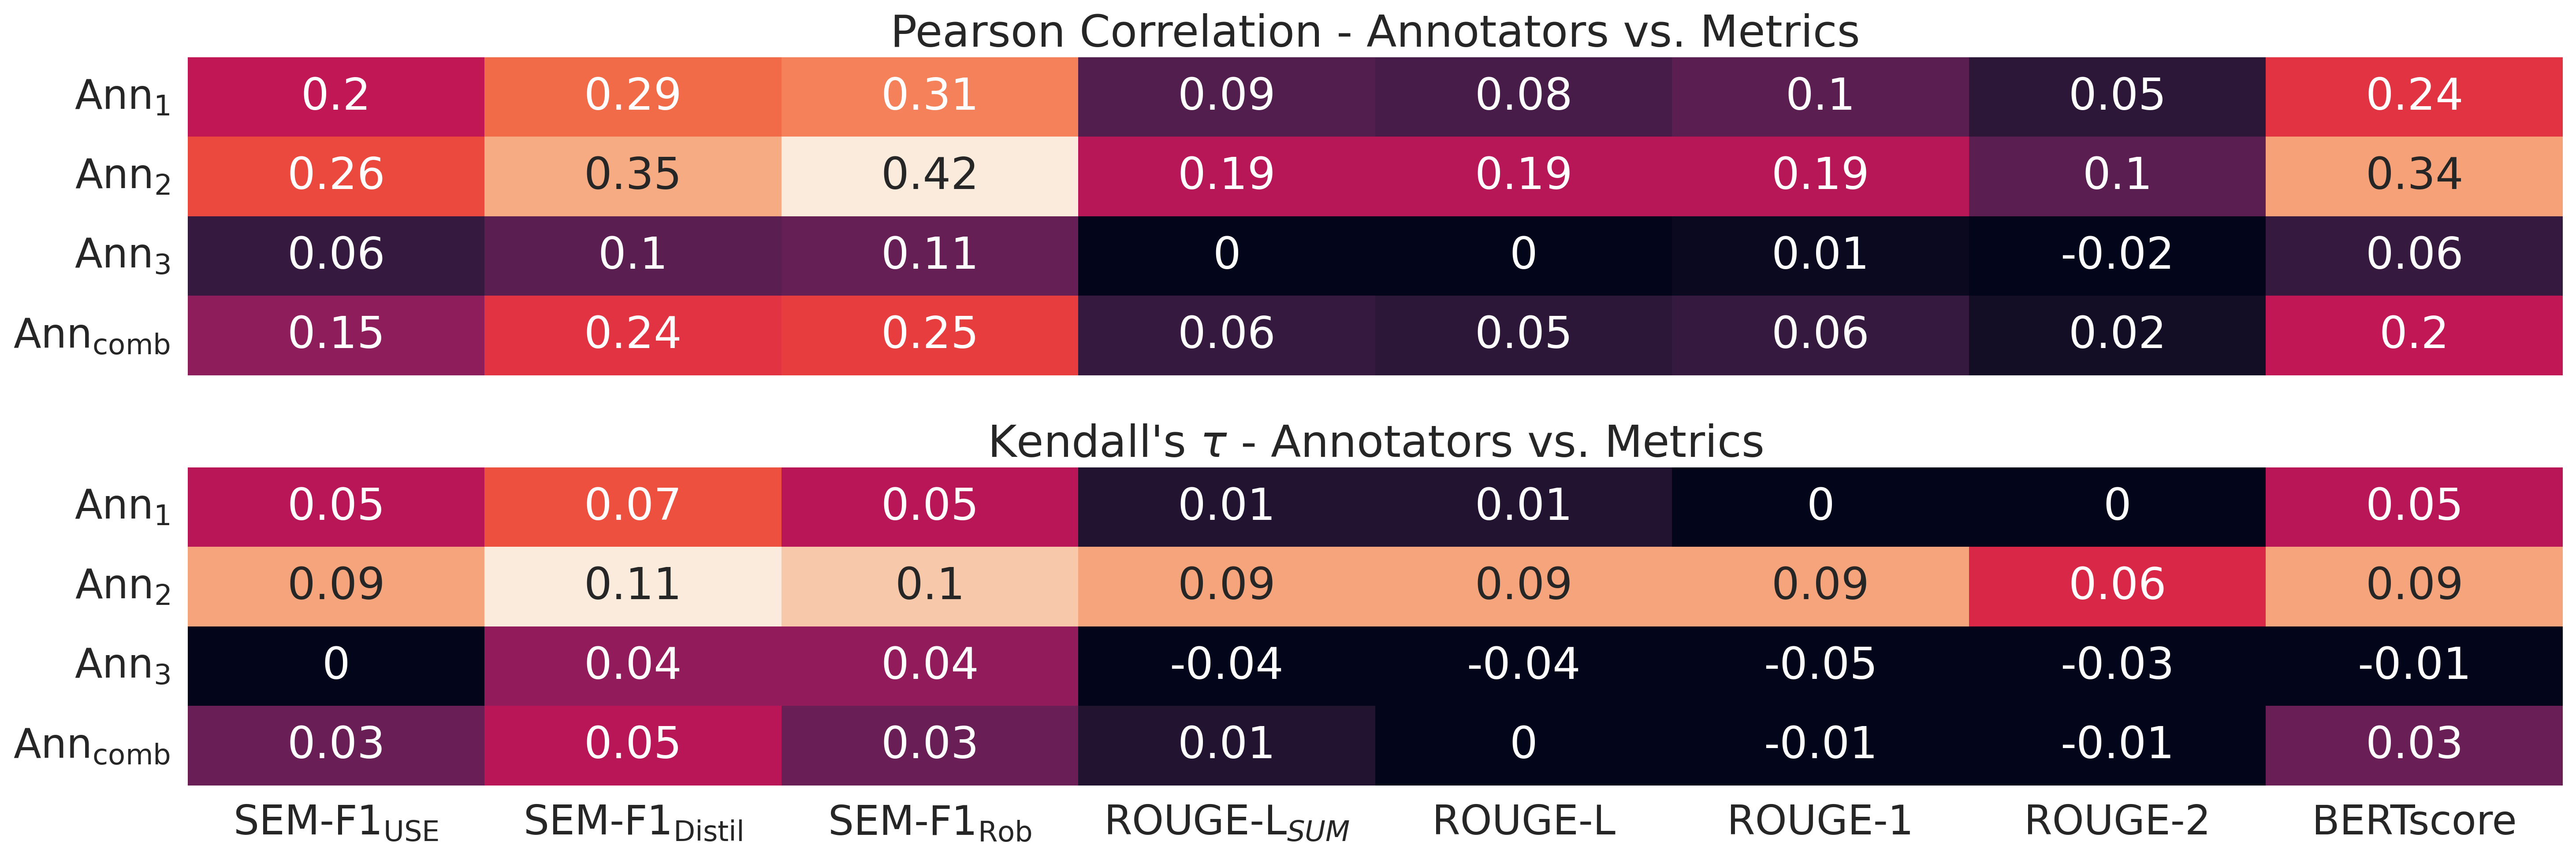

In [8]:
from scipy.stats import pearsonr, kendalltau

row = [
    'annotator_1', 'annotator_2', 'annotator_3',
    'annotator_agreement',
]

col = [
    'semf1-use', 'semf1-distil', 'semf1-rob',
    'rougeLsum', 'rougeL', 'rouge1', 'rouge2',
    'bertscore',
]
row_alias = [
    r'$\text{Ann}_1$', r'$\text{Ann}_2$', r'$\text{Ann}_3$',
    r'$\text{Ann}_{\text{comb}}$',
]
col_alias = [
    r'$\text{SEM-F1}_{\text{USE}}$', r'$\text{SEM-F1}_{\text{Distil}}$',
    r'$\text{SEM-F1}_{\text{Rob}}$',
    r'$\text{ROUGE-L}_{SUM}$',
    r'ROUGE-L', r'ROUGE-1', r'ROUGE-2',
    r'BERTscore'
]
pearson_agr = np.zeros((len(row), len(col)))
kendall_agr = np.zeros((len(row), len(col)))

for i, rname in enumerate(row):
    for j, cname in enumerate(col):

        # convert to numpy arrays and set empty cells to 0
        a = np.array(human_scores[rname], dtype=float)
        b = np.array(human_scores[cname], dtype=float)
        a[np.isnan(a)] = 0
        b[np.isnan(b)] = 0

        # ignore sample 498
        # TODO remove this
        a = np.delete(a, 498)
        b = np.delete(b, 498)

        pearson_agr[i, j] = pearsonr(a, b).statistic
        kendall_agr[i, j] = kendalltau(a, b).statistic

pearson_agr = np.round(pearson_agr, decimals=2)
pearson_agr[pearson_agr == -0] = 0

kendall_agr = np.round(kendall_agr, decimals=2)
kendall_agr[kendall_agr == -0] = 0

#print(pearson_agr)
fig, ax = plt.subplots(
    nrows=2,
    sharex=True,
    #figsize=(7.5, 3), dpi=300,
    figsize=(20, 7), dpi=300,
    layout='tight',
)
sns.heatmap(
    pearson_agr, annot=True, vmin=0, cbar=False,
    xticklabels=col_alias, yticklabels=row_alias,
    ax=ax[0]
)
sns.heatmap(
    kendall_agr, annot=True, vmin=0, cbar=False,
    xticklabels=col_alias, yticklabels=row_alias,
    ax=ax[1]
)
ax[0].set_title('Pearson Correlation - Annotators vs. Metrics')
ax[1].set_title(r"Kendall's $\tau$ - Annotators vs. Metrics")
#ax[1].tick_params(axis='x', labelrotation=90)


In [29]:
h_scores = human_scores.select(
    np.delete(np.arange(len(human_scores)), 498)
)
models = set(h_scores['model'])
#model_pref_scores = np.zeros(len(models))
model_pref_scores = {}
for i, model in enumerate(models):
    model_data = h_scores.filter(lambda x: x['model'] == model)
    ann_scores = np.array(model_data['annotator_agreement'], dtype=float)
    ann_scores[np.isnan(ann_scores)] = 0
    avg_score = np.mean(ann_scores)

    model_pref_scores[model] = round(avg_score, 2)

#model_pref_scores = np.round(model_pref_scores, decimals=2)
#pprint(dict(zip(models, model_pref_scores)))
print(json.dumps(model_pref_scores, indent=4))

templates = list(set(h_scores['template']))
#template_pref_scores = np.zeros(len(templates))
template_pref_scores = {}
for i, tmplt in enumerate(templates):
    tmplt_data = h_scores.filter(lambda x: x['template'] == tmplt)
    ann_scores = np.array(tmplt_data['annotator_agreement'], dtype=float)
    ann_scores[np.isnan(ann_scores)] = 0
    avg_score = np.mean(ann_scores)

    template_pref_scores[tmplt] = round(avg_score, 2)

#template_pref_scores = np.round(template_pref_scores, decimals=2)
#print(templates)
print(json.dumps(template_pref_scores, indent=4))
#pprint(dict(zip(templates, template_pref_scores)))



Filter: 100%|██████████| 629/629 [00:00<00:00, 19730.59 examples/s]


{
    "gemini-pro": 3.37,
    "lmsys/vicuna-13b-v1.5-16k": 3.32,
    "mosaicml/mpt-30b-chat": 3.39,
    "microsoft/Phi-3-mini-128k-instruct": 3.37,
    "mistralai/Mistral-7B-Instruct-v0.2": 3.38,
    "gpt-3.5-turbo": 3.53,
    "meta-llama/Meta-Llama-3-8B-Instruct": 3.08
}


Filter: 100%|██████████| 629/629 [00:00<00:00, 19636.17 examples/s]

{
    "l0": 3.57,
    "l4": 3.32,
    "l2": 3.42,
    "l3": 3.32,
    "l1": 3.38,
    "icl": 3.08
}


In [30]:
as_count = human_scores['dataset'].count('all_sides')
ppp_count = human_scores['dataset'].count('privacy_policy')
print(as_count/42)
print(ppp_count/42)


7.0
8.0


In [123]:
sample = human_scores.filter(lambda x: x['id'] == 22 and x['model'] != 'meta-llama/Meta-Llama-3-8B-Instruct')
print(sample)

Filter: 100%|██████████| 630/630 [00:00<00:00, 34375.96 examples/s]

Dataset({
    features: ['Column1', 'doc1', 'doc2', 'response', 'id', 'template', 'dataset', 'system', 'prompt', 'index', 'semf1-use', 'semf1-distil', 'semf1-rob', 'bertscore', 'hashcode', 'model', 'sys_text_id', 'prompt_text_id', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2', 'annotator_1', 'annotator_2', 'annotator_3', 'annotator_agreement'],
    num_rows: 36
})


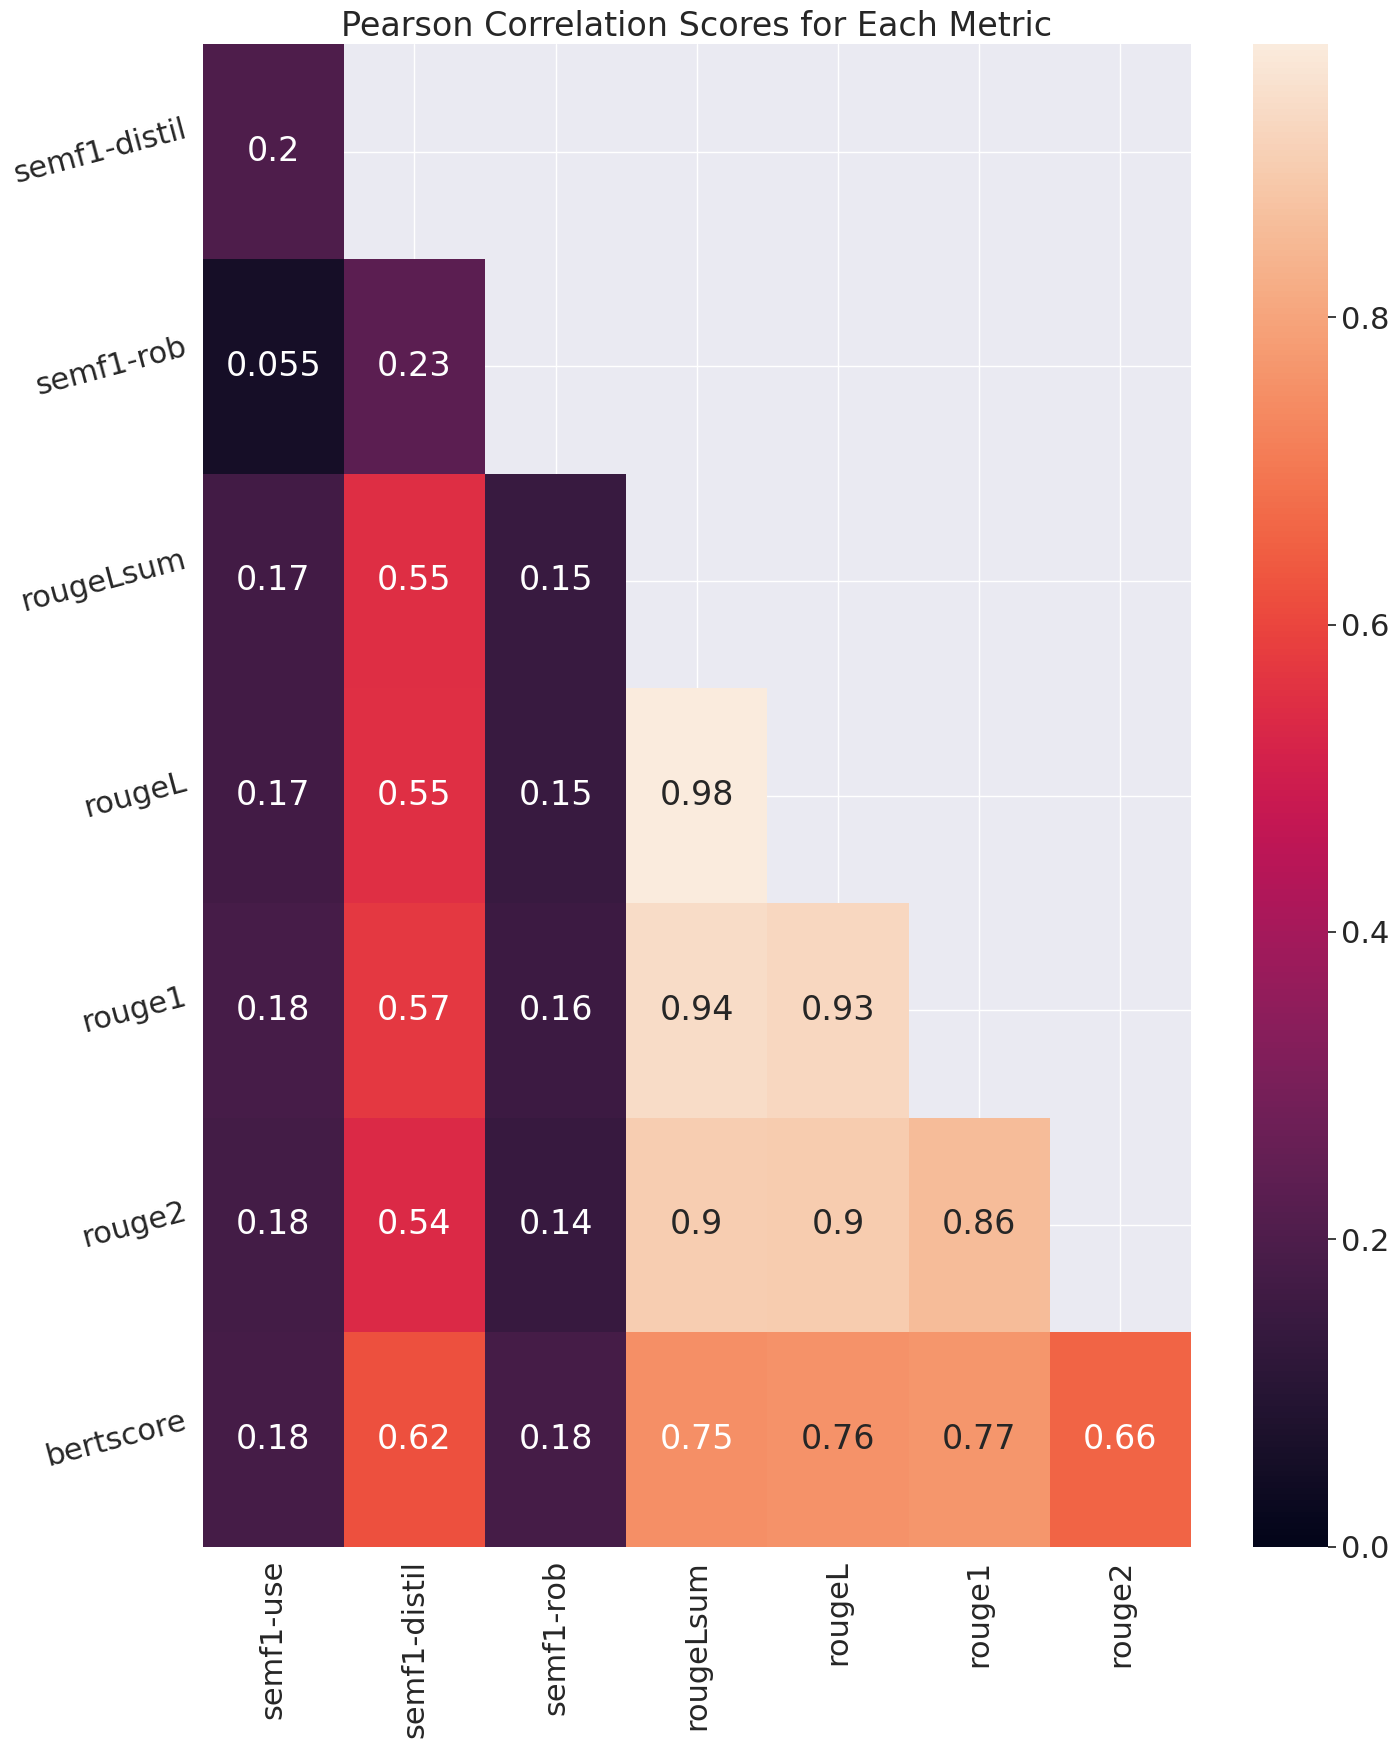

In [6]:
from scipy.stats import spearmanr, pearsonr, kendalltau

metrics = [
    'semf1-use', 'semf1-distil', 'semf1-rob',
    'rougeLsum', 'rougeL', 'rouge1', 'rouge2',
    'bertscore',
]

wh = 15.0, 18.0
sns.set_theme(rc={'figure.figsize': wh}, font_scale=2.0)
cor_mat = np.zeros((len(metrics), len(metrics)))

for i, m1 in enumerate(metrics):
    for j, m2 in enumerate(metrics):
        score = pearsonr(ds[m1], ds[m2]).statistic
        cor_mat[i, j] = score

fig, ax = plt.subplots()
sns.heatmap(
    cor_mat[1:, :-1],
    #cor_mat,
    annot=True,
    vmin=0,
    xticklabels=metrics[:-1],
    yticklabels=metrics[1:],
    #xticklabels=metrics,
    #yticklabels=metrics,
    mask=np.triu(np.ones(cor_mat[1:, :-1].shape, dtype=bool), k=1),
    #mask=np.triu(np.ones(cor_mat.shape, dtype=bool)),
)
plt.title(r"Pearson Correlation Scores for Each Metric")
#ax.tick_params(axis='x', labelrotation=15)
ax.tick_params(axis='y', labelrotation=15)
plt.gcf().subplots_adjust(
    bottom=0.15,
    left=0.15,
)
plt.tight_layout()

In [11]:
results = Dataset.from_list(results)
print(results)

NameError: name 'results' is not defined

In [33]:
ds_names = ['all_sides', 'privacy_policy']
metrics = [
    'semf1-use', 'semf1-distil', 'semf1-rob',
    'rougeLsum', 'rougeL', 'rouge1', 'rouge2',
    'bertscore',
]
num_proc = 28
tmplt_ids = sorted(set(ds['template']))
models = sorted(set(ds['model']))
results = []
for name in ds_names:
    print(f'on dataset {name}')
    data = ds.filter(
        lambda x: x['dataset'] == name,
        num_proc=num_proc
    )
    for tid in tmplt_ids:
        print(f'*** on template {tid} ***')
        tdata = data.filter(
            lambda x: x['template'] == tid,
            num_proc=num_proc,
        )

        sys_ids = sorted(set(tdata['sys_text_id']))
        prmpt_ids = sorted(set(tdata['prompt_text_id']))
        for mod, sid, pid in product(models, sys_ids, prmpt_ids):
            print(f'on model: {mod}, sid: {sid+1} of {len(sys_ids)}, pid: {pid+1} of {len(prmpt_ids)}')
            pdata = tdata.filter(
                lambda x: x['sys_text_id'] == sid 
                        and x['prompt_text_id'] == pid
                        and x['model'] == mod,
                num_proc=num_proc
            )
            sample = {
                'dataset': name, 'sid': sid, 'pid': pid, 
                'template': tid, 'model': mod, 
            }
            sample.update({
                metric: np.mean(pdata[metric])
                for metric in metrics
            })
            results.append(sample)
results = Dataset.from_list(results)
print(results)


on dataset all_sides


Filter (num_proc=20): 100%|██████████| 961792/961792 [00:01<00:00, 846019.39 examples/s] 


*** on template icl ***


Filter: 100%|██████████| 484432/484432 [00:18<00:00, 25597.37 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34980.87 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34098.49 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33814.96 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33398.90 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32516.62 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34801.60 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34498.62 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33344.02 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33101.22 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32643.05 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33699.59 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34579.14 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33191.31 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32901.50 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34861.07 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 36567.27 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33326.64 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33185.05 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34088.95 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33362.91 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33061.22 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32979.10 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34742.28 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33423.89 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32688.84 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34765.76 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34415.47 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34962.04 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33242.59 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33069.41 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34196.47 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33406.16 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33014.74 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32708.46 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32799.48 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34167.97 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33176.88 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32848.06 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32685.07 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35664.84 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32795.52 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33966.37 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34192.66 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33163.90 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32628.37 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34594.28 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33615.27 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32631.58 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34798.87 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34245.49 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32886.37 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32890.85 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32753.04 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34159.73 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32690.66 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32971.06 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34406.14 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33130.10 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33049.75 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35259.99 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33132.25 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33390.43 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32918.56 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33249.87 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32887.31 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34169.57 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33948.00 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34513.34 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32605.39 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32976.58 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34888.31 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34590.59 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33074.13 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33080.94 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32654.27 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34815.74 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33040.22 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34629.16 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34444.75 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32673.61 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34557.73 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34020.94 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32801.34 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34794.05 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34326.70 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33656.63 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33980.82 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34878.00 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33015.54 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32836.03 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33838.73 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33205.93 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32893.61 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34540.92 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34781.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32842.36 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33340.35 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34636.06 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34521.83 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 36092.05 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33053.76 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34665.65 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34717.10 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33241.36 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32964.93 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32665.18 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32817.50 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34677.79 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33951.41 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32462.28 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32940.06 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32505.25 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33187.49 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33167.67 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32893.73 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32921.79 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33484.62 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34655.72 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32469.24 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32955.84 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33522.23 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32936.63 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32275.58 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35060.62 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34292.60 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34737.41 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34620.63 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33199.81 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35210.52 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34228.24 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32887.13 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32949.19 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34614.06 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34630.87 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34026.34 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33056.08 examples/s]


*** on template l0 ***


Filter: 100%|██████████| 484432/484432 [00:19<00:00, 24708.51 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33747.15 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33776.39 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33123.88 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33299.81 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34970.94 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32742.09 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33618.80 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33319.32 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34867.32 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34947.14 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34875.71 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33515.48 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33926.46 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34127.19 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33555.24 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34114.80 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33955.01 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 36262.10 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33862.00 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35141.22 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33521.31 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:01<00:00, 12722.61 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33700.61 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 36909.43 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32893.10 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33287.46 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35305.97 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34111.40 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35158.83 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33177.65 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32973.87 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33357.67 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35168.15 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34321.64 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33642.24 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33137.80 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35105.83 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34063.10 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33162.42 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33686.62 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35836.85 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33594.62 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33095.60 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33722.97 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35352.36 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33427.10 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33732.92 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33764.82 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33742.27 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33226.59 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33836.62 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33056.85 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33212.02 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35166.19 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34577.57 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33578.54 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33684.57 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35190.38 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33375.09 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34037.12 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32617.11 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35335.91 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34173.61 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33149.51 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33837.09 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34795.91 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33364.05 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34930.66 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35222.87 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33471.49 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34161.33 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33679.16 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34807.07 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35062.67 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35005.97 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33459.96 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33917.08 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34471.67 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33649.59 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33018.76 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32939.51 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34705.57 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35393.27 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:01<00:00, 10935.67 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34416.97 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35316.35 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32793.98 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33954.76 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35104.83 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32915.76 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33068.60 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34707.61 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33908.87 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33742.38 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33717.45 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33745.68 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 37075.35 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:01<00:00, 17281.31 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33850.50 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35407.19 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35449.35 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34288.48 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 36945.01 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33461.65 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33633.25 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33128.22 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33232.20 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35643.03 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33984.31 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33634.58 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35076.53 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33145.80 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35179.50 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33372.58 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34098.87 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35596.87 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33394.90 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33151.42 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 32898.45 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34589.29 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35412.15 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33212.04 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33720.78 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33611.38 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 36938.15 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33461.48 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 36101.84 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35076.06 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33192.51 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 34894.77 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35231.38 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 36259.12 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33247.88 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 35444.48 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33524.12 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18632/18632 [00:00<00:00, 33519.01 examples/s]


*** on template l1 ***


Filter: 100%|██████████| 484432/484432 [00:19<00:00, 24870.91 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181185.71 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173495.40 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177817.94 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174549.73 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173128.72 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176819.10 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:01<00:00, 107950.34 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176103.67 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177139.43 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174225.53 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174007.36 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172738.91 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173992.35 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179311.95 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 170500.24 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178746.07 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173808.00 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177594.27 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178677.82 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175137.19 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175325.20 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178327.22 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175226.43 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180744.08 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174045.97 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177123.83 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183031.87 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 187486.30 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182180.79 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173206.67 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177701.34 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174958.10 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176093.65 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176234.28 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175266.12 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180202.84 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174052.46 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183874.12 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174174.46 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177922.64 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176273.73 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176358.86 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173402.43 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179713.22 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174408.03 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176918.32 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 184538.99 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172718.06 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 184254.76 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176320.76 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173504.31 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173891.25 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183154.40 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179074.30 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175083.92 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175272.12 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182839.38 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176389.37 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173257.93 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173704.08 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174000.24 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:01<00:00, 77494.03 examples/s] 


on model: gemini-pro, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176174.98 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175324.32 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175927.55 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179145.37 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175468.25 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180243.78 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172965.97 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175067.89 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183701.12 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175163.74 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173383.82 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182582.22 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179748.93 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175436.54 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173051.09 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176917.27 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173818.59 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175899.93 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176073.91 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183747.34 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173650.00 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176130.46 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174671.95 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182561.59 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176072.18 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177277.16 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176249.24 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178580.23 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176144.31 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172733.28 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181427.89 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173501.13 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176158.16 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177687.90 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178988.12 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178705.24 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179873.20 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179073.74 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173824.48 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181244.17 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173138.60 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182195.76 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 169854.36 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175492.78 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177806.81 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175568.18 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175746.69 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174837.69 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171213.90 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173857.21 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177070.30 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172834.14 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176898.20 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172656.05 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:01<00:00, 108712.62 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176624.68 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 166516.05 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172913.15 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180388.46 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183329.86 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176560.48 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173517.07 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171379.72 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174974.36 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176992.50 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175653.62 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181100.05 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176677.78 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173964.75 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181677.74 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 163074.32 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175602.26 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176507.59 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182027.28 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 170576.20 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173225.29 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173150.69 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 187349.94 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171362.52 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172091.63 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174895.11 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174096.52 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175200.75 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182299.95 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174926.48 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176997.06 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178422.14 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 184066.52 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172396.57 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175334.30 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181930.24 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172167.93 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 164836.17 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173514.66 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173565.49 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:01<00:00, 76380.77 examples/s] 


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177709.17 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181476.55 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 162014.86 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173913.36 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177577.88 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176374.34 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 170790.09 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178534.49 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174354.29 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174938.86 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178601.45 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176354.64 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179293.33 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175771.50 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 168406.94 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181377.41 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179194.56 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180121.22 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183471.63 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175507.71 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173491.99 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175188.08 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175412.86 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176398.92 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174257.33 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176227.38 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174755.53 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181125.66 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179960.24 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175662.30 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 170265.88 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176401.61 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176126.39 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172197.81 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181783.92 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174571.96 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174876.71 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 169933.22 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177021.77 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171001.19 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178430.69 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178171.96 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177251.73 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171566.76 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173910.07 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 170173.65 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182104.16 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179601.81 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179299.30 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179727.27 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177980.94 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178638.91 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178189.48 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172052.32 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:01<00:00, 109503.79 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176040.94 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174098.70 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175981.83 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 168252.75 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171285.01 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173522.47 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176339.31 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174503.30 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180780.82 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 169904.58 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179067.12 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179303.88 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176215.36 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173300.05 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173930.15 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173955.46 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174292.51 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178073.56 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175700.41 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175915.18 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 185851.21 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181271.71 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177911.05 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179505.69 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179191.48 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178690.48 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 170724.05 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180999.33 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172305.59 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175949.24 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172491.56 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172865.72 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180175.88 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177071.90 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173318.31 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 169848.13 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181578.70 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181478.08 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173055.64 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 167486.57 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:01<00:00, 77206.49 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176865.22 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176639.00 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177475.75 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174054.50 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176423.11 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179845.46 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176981.07 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 169511.67 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175181.70 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175484.26 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176131.70 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171875.80 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171763.03 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:01<00:00, 107389.10 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175865.64 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 184773.73 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174922.95 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175446.14 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175245.19 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175390.13 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 167668.94 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175116.19 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183081.99 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175977.96 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173016.56 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177744.38 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171489.58 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 166488.51 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181478.29 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181682.34 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179629.57 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174794.18 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 168969.10 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171295.10 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174502.33 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171988.23 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175340.40 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181599.01 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174369.85 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180984.45 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:01<00:00, 106141.30 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172829.64 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175960.08 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180170.54 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181973.56 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172223.18 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177158.11 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181559.93 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173762.79 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173958.70 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174941.80 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173581.97 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176047.04 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 184632.95 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175094.42 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181962.97 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181885.73 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177719.98 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 169748.57 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174580.54 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 169454.10 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175139.30 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178508.64 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179258.58 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174361.48 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174937.49 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176037.97 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175299.00 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 189329.99 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171922.35 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 170533.91 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179730.58 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176178.86 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175382.94 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182644.47 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176584.87 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180114.37 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176464.00 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176148.73 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176878.93 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174550.27 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173973.03 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177995.03 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 169454.79 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173637.75 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177410.43 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174706.26 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175071.86 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 168324.01 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181094.49 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174480.12 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181784.93 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171702.98 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178516.44 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175799.08 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178677.15 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179522.59 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 169669.15 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176907.46 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179483.42 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 186454.49 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176262.45 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177480.99 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180333.20 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176978.62 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172799.31 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183236.37 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171362.66 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176695.86 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177249.52 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178608.85 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178933.97 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175389.64 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175054.17 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 169511.40 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172941.28 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176552.95 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174950.61 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176144.11 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 168278.16 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171562.61 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175677.70 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 169341.24 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173222.74 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172585.13 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180340.90 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174062.40 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180601.59 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179374.05 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 184383.12 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179316.84 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177945.33 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179859.23 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181411.78 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173702.68 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175796.41 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176222.26 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 184202.97 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172168.97 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175199.37 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181025.80 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174286.04 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172718.06 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174759.78 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173334.17 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174009.25 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171377.37 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172086.23 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174510.66 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174605.06 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179687.34 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176179.85 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 170078.33 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178823.52 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183491.77 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180899.93 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 169440.42 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176732.67 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173631.48 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172858.22 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176226.03 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177556.49 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174173.01 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179097.90 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176243.97 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173232.54 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 170957.99 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173129.01 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176688.57 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175318.61 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177204.51 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174130.90 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179679.03 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175043.97 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174375.25 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178023.36 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171288.25 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176317.04 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 170175.37 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180281.25 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174669.07 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174635.55 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177586.75 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174670.63 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176061.92 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175226.14 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176447.31 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182395.09 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 169237.00 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181192.48 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171246.73 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175493.86 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178338.26 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181058.72 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183021.85 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178334.65 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174726.87 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173249.39 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175493.17 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174664.77 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175864.50 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175757.91 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181294.84 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176531.01 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178828.08 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 168260.18 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182285.38 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176586.51 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176006.35 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179591.54 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180404.81 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173630.13 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176389.07 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172104.28 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175195.79 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177325.23 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180018.53 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180802.67 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173633.98 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175652.33 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182429.32 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177221.43 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177250.02 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177173.87 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178308.15 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180279.38 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174686.59 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175553.69 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177980.84 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175255.41 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176547.37 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175921.96 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173881.34 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178859.03 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179508.11 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182995.87 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176941.50 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173221.40 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178245.21 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175706.44 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174466.73 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178843.01 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175369.66 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179642.27 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174453.05 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177297.63 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175133.17 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178846.03 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176703.10 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174648.62 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175486.92 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174947.77 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182699.82 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175457.66 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175128.11 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175877.37 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177216.16 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175793.79 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176638.60 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177483.45 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 186239.81 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176007.44 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174891.29 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177069.75 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179442.21 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177085.35 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176053.59 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173778.39 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176741.72 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175364.79 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175819.10 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174285.95 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175797.45 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177368.00 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181258.20 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175385.60 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177642.77 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175350.33 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172992.96 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179724.02 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 167503.94 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175553.98 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175701.25 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174465.27 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178466.09 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174167.87 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176819.35 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173999.76 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179641.08 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174965.89 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179923.31 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180230.74 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 161903.88 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177180.90 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 190334.78 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 185652.75 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172380.79 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174998.31 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173605.15 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172683.28 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173957.15 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179499.50 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179206.02 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173763.56 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182289.63 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181888.43 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177681.49 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176004.47 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177167.90 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176876.43 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178020.52 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171486.28 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172500.03 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176013.69 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175768.58 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181357.26 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171798.81 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176253.66 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177208.87 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175847.29 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178852.02 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182515.43 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176266.48 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180905.27 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175914.98 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177230.23 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179651.87 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174504.37 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171079.48 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175545.75 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176284.17 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182355.62 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172551.21 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173893.04 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179635.71 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 186801.85 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181733.67 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181810.83 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174268.36 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178449.28 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181670.62 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171500.49 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174859.25 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176471.07 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174322.74 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174380.74 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173260.33 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173606.31 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175424.82 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177177.84 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175153.48 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177427.69 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174502.09 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175537.91 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174561.92 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 170926.90 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175035.64 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175546.88 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173091.10 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175669.21 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175541.56 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171299.09 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179447.67 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176995.40 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174168.11 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177570.21 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177226.16 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173859.14 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173970.90 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175931.12 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177683.00 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174872.61 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176773.20 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175637.23 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173733.09 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177015.40 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174022.81 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177206.26 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182603.61 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175505.39 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180946.53 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173843.04 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172876.19 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176040.75 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179486.31 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174534.43 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173986.68 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179404.98 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178297.73 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 169461.64 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176737.97 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178136.07 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 184675.60 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175762.01 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172594.94 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174180.92 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177092.02 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176267.42 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174541.16 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180784.01 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177492.02 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175412.08 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177416.57 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176534.60 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 170143.87 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178938.53 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176147.78 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175843.58 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175697.30 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174615.70 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182895.23 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175474.06 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176293.12 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176121.53 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176353.89 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177683.26 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173079.88 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175645.92 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182322.97 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174901.47 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175963.30 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174476.57 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181801.31 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183528.07 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182622.22 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174959.32 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175334.10 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179192.97 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183320.83 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181005.88 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179246.76 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178603.39 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174925.94 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177920.67 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176259.77 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173321.91 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176574.74 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172538.12 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171573.96 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175218.57 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176035.10 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180772.67 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175609.75 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173207.15 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177241.13 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180057.05 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175800.07 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177559.12 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174222.32 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 186420.51 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172284.12 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176992.75 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173949.07 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173033.47 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181320.44 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176287.60 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176817.50 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179638.60 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173726.09 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181473.34 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183444.98 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173674.74 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176355.43 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181104.56 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175504.95 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175704.51 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181498.89 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 165792.39 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174282.11 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177441.34 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180051.56 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175355.94 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180869.31 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180443.02 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171876.55 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174195.87 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176062.96 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179529.86 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177036.85 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180440.84 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174479.83 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175624.21 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176481.33 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178642.38 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173328.93 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176182.93 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173132.32 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176964.14 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173499.40 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174330.03 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176467.73 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173129.35 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174790.66 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177933.58 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175467.26 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180633.47 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176177.76 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175079.02 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174388.38 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 184210.68 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180170.54 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171141.06 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:01<00:00, 126851.95 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178751.84 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181234.55 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174698.16 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175953.50 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181015.21 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175832.26 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:01<00:00, 107222.17 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175212.88 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183062.53 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177290.99 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181444.63 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172890.10 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177415.71 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179257.81 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 168037.27 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174344.71 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181929.77 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173779.21 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172890.30 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180287.07 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174038.17 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177159.31 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173427.83 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180060.22 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 162965.12 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179085.08 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174641.99 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175027.31 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172046.40 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180546.31 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179437.11 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172648.52 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175350.72 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177443.86 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175837.89 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176936.25 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175616.17 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175726.05 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174882.73 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174329.49 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174587.32 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174800.00 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175667.83 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174552.56 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 166218.46 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176560.93 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177832.40 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172893.45 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177599.16 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176523.24 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172457.83 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173844.83 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182482.83 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175087.31 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181178.83 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173116.55 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177814.85 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176624.48 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174068.12 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174857.98 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172735.29 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176310.22 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176248.24 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172732.85 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173416.43 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 165241.35 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181200.62 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181965.19 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180662.55 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177410.63 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 169341.97 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178235.81 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177825.47 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177814.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174357.01 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174600.38 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171416.88 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173526.13 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182166.25 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174430.95 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181426.21 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181907.06 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174677.66 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174527.22 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177237.86 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177046.53 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174385.85 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182501.26 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178663.83 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173276.42 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173043.00 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177625.45 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172764.17 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176427.79 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177968.17 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181234.77 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181227.78 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176603.92 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174371.50 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176161.58 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181276.91 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180505.75 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172326.72 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175625.74 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179232.73 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 170948.92 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176160.64 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176457.07 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174312.97 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183741.18 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181346.27 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175335.09 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 170607.20 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178502.02 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 186336.78 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176517.91 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180177.23 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176449.30 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182360.46 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183956.14 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172242.02 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176301.62 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175298.90 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174747.08 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175200.75 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175122.96 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176566.36 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174405.94 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177251.78 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175502.04 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174909.49 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179607.80 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177671.39 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181700.39 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177953.79 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180538.22 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175542.05 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183357.23 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175114.97 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175502.68 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175270.54 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178081.12 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180849.59 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174570.55 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172721.26 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176179.95 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181109.92 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175688.37 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179073.48 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182622.33 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171188.63 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182161.58 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174675.75 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176385.98 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181346.06 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174022.86 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 166329.98 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176875.98 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178767.33 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176539.14 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174200.33 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176996.46 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176418.33 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 168173.05 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 169360.23 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174492.69 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173957.88 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174875.88 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178363.80 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 184487.15 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176214.56 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 170744.19 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175362.18 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173935.23 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178427.18 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175399.33 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175508.64 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176860.41 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176972.66 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175846.35 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173293.71 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176466.44 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172279.52 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172621.82 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183297.18 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176332.80 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183188.42 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174657.01 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181429.26 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175150.24 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172258.30 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179609.24 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174821.36 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176814.05 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175405.68 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182351.47 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172091.20 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 187739.99 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174524.64 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 184099.15 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173663.89 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173120.34 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178803.89 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175228.35 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175328.30 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182407.39 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174000.39 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171255.45 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174829.67 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182777.86 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180817.00 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174783.92 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179084.20 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176981.17 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176696.16 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173519.24 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181674.68 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174814.47 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177767.98 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 170575.83 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178431.46 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175744.03 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176833.70 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176540.88 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176517.01 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178434.56 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175870.54 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177603.60 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176485.07 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180656.49 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178171.66 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181902.82 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174525.37 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175574.00 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176037.92 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174174.03 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182960.47 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173689.03 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183610.81 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177625.40 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175885.88 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174943.51 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174396.07 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174099.58 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 168394.96 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174106.65 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174435.48 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175258.61 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173675.61 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 170685.88 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172029.36 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176059.68 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174558.26 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176294.11 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175954.09 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181906.16 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180387.99 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172890.63 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178494.83 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172681.23 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179233.04 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175630.77 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174821.11 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176226.33 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171655.27 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 167960.97 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177880.27 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176530.02 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171099.89 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174458.45 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178081.17 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174504.96 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174849.33 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177866.71 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174894.13 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171195.71 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175462.93 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181410.15 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179741.79 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179771.82 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176861.66 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176468.48 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172701.74 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179057.84 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182224.17 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176903.25 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 184678.54 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181393.04 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175829.98 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177139.84 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181631.93 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180219.77 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 181393.46 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176618.39 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180022.21 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 178057.23 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172286.97 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173781.63 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175953.00 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177865.95 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175779.80 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174098.70 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 183419.04 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177354.61 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172824.77 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176871.57 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 179104.78 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173518.18 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174908.66 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175431.71 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171933.37 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173863.98 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172387.73 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 182629.21 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 177080.18 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 186089.02 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171747.08 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 171370.98 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174375.59 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174794.92 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175254.82 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 173566.21 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 185157.12 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175125.81 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 176204.03 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 180143.54 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175789.29 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 175670.30 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 186245.58 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 174230.29 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 149056/149056 [00:00<00:00, 172138.02 examples/s]


*** on template l2 ***


Filter: 100%|██████████| 484432/484432 [00:19<00:00, 24689.46 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:01<00:00, 86332.73 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144862.63 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149976.96 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144060.17 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144565.76 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149514.90 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141508.48 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144778.90 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147793.77 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146666.15 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145861.97 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143672.70 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149713.01 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141036.57 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145955.45 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147836.97 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141889.29 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144511.35 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143106.21 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141652.04 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142095.65 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145230.33 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146870.86 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143283.97 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143230.92 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142245.19 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146982.83 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143613.55 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 137080.11 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143637.31 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145697.58 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145072.30 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147588.76 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149658.49 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 139165.17 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148100.75 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145677.30 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148991.92 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151204.38 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144632.60 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145720.45 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:01<00:00, 58853.51 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143104.28 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148411.54 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140474.06 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150587.62 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143865.33 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140243.40 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141351.41 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146693.09 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143877.78 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148091.49 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146507.82 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147476.65 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149291.77 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141314.86 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144280.57 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149119.28 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140527.99 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140569.24 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145105.43 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145952.64 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140900.62 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146627.95 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143802.06 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143732.81 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143751.50 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144402.63 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144229.93 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143107.56 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147843.54 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143654.21 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146135.95 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143049.89 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146470.84 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147522.22 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146159.64 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146098.21 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143530.38 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143301.58 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143848.74 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140633.74 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144093.64 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144581.18 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151840.28 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142311.37 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149548.80 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148179.80 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143649.19 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144305.26 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142723.67 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145816.52 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149891.39 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140446.63 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141703.11 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145321.12 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:01<00:00, 84671.02 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144612.30 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141325.72 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151423.97 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145962.77 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141387.13 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144208.46 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146475.14 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150163.47 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144091.96 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148444.29 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141594.50 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142467.98 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148229.55 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143415.14 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146520.64 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140945.47 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 155153.73 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143320.41 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148696.99 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150786.46 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144253.14 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143866.70 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144032.07 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142677.94 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146145.06 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141755.07 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143160.43 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143112.89 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143347.62 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144175.25 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143029.29 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147886.21 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146126.48 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143410.49 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151186.98 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146463.47 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145171.34 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143345.03 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145343.01 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146265.46 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:01<00:00, 60766.33 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145213.60 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 152198.40 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144032.20 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145649.83 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141990.74 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143387.86 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143643.21 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147261.93 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143772.87 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145027.25 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145297.25 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143767.63 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146247.12 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144701.11 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145843.00 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145022.05 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145705.77 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144574.23 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145166.08 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143351.61 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144591.84 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 139469.54 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148214.41 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151346.21 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142655.28 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142045.24 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141301.87 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141743.16 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145751.56 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143952.34 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143969.40 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149220.03 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 152841.21 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143146.92 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144474.13 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143152.21 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144125.93 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 152215.00 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145262.91 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145186.13 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144155.17 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143325.93 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149227.06 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144596.87 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141588.90 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143819.13 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145157.72 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143946.24 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146709.84 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145833.30 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147344.76 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145058.48 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143299.17 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148400.08 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:01<00:00, 86610.14 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142978.92 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 136209.26 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143931.31 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145406.07 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145831.57 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144377.06 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150435.04 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145256.56 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142546.55 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144016.98 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143529.59 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146420.62 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147709.41 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145192.02 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 135708.76 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144586.62 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144091.91 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144514.92 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141175.22 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146427.98 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144317.78 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145708.81 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151030.17 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145121.02 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145067.14 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 153937.05 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145283.75 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145970.40 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 154775.16 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149385.47 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145111.45 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144998.95 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148573.12 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145981.81 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144602.98 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143893.90 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149852.54 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145204.02 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144809.53 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145752.61 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145642.05 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143704.53 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142435.01 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151047.01 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143883.34 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142064.65 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143570.15 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141177.64 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146108.54 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 152445.67 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140466.70 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149642.73 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149821.56 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146681.48 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144093.77 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145986.90 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148380.02 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149463.14 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143317.26 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144671.47 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143260.68 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146356.64 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 155743.19 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147960.55 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143878.97 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145155.97 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145206.09 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143726.86 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145575.76 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143587.65 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142344.94 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147874.64 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148184.25 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 139647.32 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145223.67 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145843.41 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145063.50 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147156.60 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145327.51 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145087.07 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143881.53 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143133.51 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141749.03 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142968.19 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 135269.33 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143361.51 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149478.01 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145061.44 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143144.83 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144968.11 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148199.47 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 139315.68 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148970.71 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151340.40 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144194.63 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143848.16 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146204.53 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143465.03 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151334.20 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145889.56 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144814.58 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144897.19 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147020.99 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144361.15 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147812.92 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145642.23 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 153492.04 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147901.23 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143074.55 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150916.47 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 153269.17 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147095.15 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144615.83 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145177.23 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150639.33 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145351.26 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144529.26 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146247.76 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 154141.64 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146115.19 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143342.01 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148996.27 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146743.95 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147472.94 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141355.16 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145948.96 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144836.90 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142441.28 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144548.38 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144630.59 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141760.30 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143678.86 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143339.07 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143004.64 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144612.48 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143720.83 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143088.69 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149333.76 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 136809.53 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143875.18 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145418.74 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145173.95 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143009.79 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147754.05 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143713.87 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144708.79 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149160.22 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142117.22 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142069.64 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147926.19 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146851.04 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145614.19 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151824.85 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145740.42 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143355.81 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146762.69 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149401.23 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144183.76 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 155690.34 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143385.54 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140031.55 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149925.61 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 139833.98 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149715.60 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141943.03 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144057.20 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144047.47 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144521.69 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144873.69 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 138742.72 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145408.01 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141844.14 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147914.71 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 155758.81 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145934.47 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140568.06 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149156.05 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142504.01 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145604.20 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146694.83 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149290.73 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145165.23 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144742.30 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145871.63 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142069.13 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141078.33 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145424.29 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145028.82 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144259.44 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145213.87 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143716.38 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145961.45 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143201.62 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144312.41 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144400.27 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146147.75 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148484.71 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146515.97 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144013.76 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144532.65 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142127.65 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140176.02 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142793.43 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149844.97 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143526.78 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149290.82 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143519.88 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144612.71 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149007.40 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145892.06 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143891.16 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142527.36 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151981.04 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 137815.45 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144015.17 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 137260.04 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145811.48 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146464.85 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146583.30 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146970.30 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145808.72 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145860.33 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143711.40 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 152688.42 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144312.45 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143671.46 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146519.81 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142107.36 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148845.91 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144120.48 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148422.34 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144878.75 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142544.95 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145210.41 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148247.78 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150034.41 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146828.41 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142801.38 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149961.28 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144241.69 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144580.15 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147063.74 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144682.85 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145687.44 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145608.27 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144046.72 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143532.79 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144307.70 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147571.01 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149269.39 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144383.91 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 137861.60 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142792.77 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149605.87 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142169.32 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142980.27 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146358.60 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146473.86 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144000.31 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147279.97 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144060.92 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149054.48 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143677.36 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144310.23 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144878.43 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 153567.40 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143940.01 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147462.79 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145155.07 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142780.99 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146433.42 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144612.26 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146013.09 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143454.59 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 139653.44 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141129.50 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141610.24 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141180.79 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141294.68 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145446.93 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143057.92 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144724.34 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148523.70 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143814.41 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144401.92 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 139645.37 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144521.96 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143933.52 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145438.76 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140390.53 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141260.11 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150680.14 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143176.74 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 152274.67 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149725.87 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143979.17 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144340.26 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145501.14 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149212.48 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142359.50 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142824.83 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142782.51 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147200.35 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141575.14 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143754.71 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143634.98 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147204.14 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147572.73 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144183.72 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 152377.35 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146352.89 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144826.93 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150986.65 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148957.37 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151354.17 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144882.91 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142384.70 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148480.81 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143309.28 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150926.43 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142999.80 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 154458.39 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149390.38 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149324.44 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142536.80 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 138663.25 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143378.13 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145046.45 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 152370.32 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150699.56 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141970.28 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140229.26 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143694.58 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143486.46 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146679.73 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143912.14 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142451.19 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141938.26 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144537.59 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148369.51 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145465.34 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144445.96 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148024.63 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149071.02 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143282.57 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145058.57 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145750.39 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142837.97 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146963.39 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144547.62 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144001.11 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142219.39 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147086.02 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144303.53 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143432.60 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141861.73 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142051.74 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142284.72 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144403.61 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146757.96 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145290.41 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149772.17 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144814.90 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148893.70 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143307.62 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146748.50 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:01<00:00, 84920.25 examples/s] 


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143995.22 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141093.78 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147603.30 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 137842.71 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143044.43 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144238.18 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143051.37 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145077.10 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 154540.19 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141566.72 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144068.45 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146794.99 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143450.15 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145740.78 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146802.30 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149078.18 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149162.03 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148100.14 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147610.22 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141873.54 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143941.60 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141380.78 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145055.56 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144009.73 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140551.37 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143859.73 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148445.65 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143582.42 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147161.86 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144122.96 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146799.27 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149370.10 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145252.92 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143477.28 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144233.30 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144489.89 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146386.75 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146624.55 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 152267.45 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 139885.38 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143188.19 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151744.91 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141517.32 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146338.46 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147372.22 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142455.86 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144186.95 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141459.94 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144709.82 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150241.61 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146643.63 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151531.29 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150845.93 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149430.03 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144168.29 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149618.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142979.70 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 155055.02 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145302.88 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144431.72 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141268.75 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147173.37 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144782.07 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143172.01 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146949.07 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148651.07 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140454.33 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143320.41 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144173.83 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143997.92 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 138865.17 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143230.49 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145049.37 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143185.65 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149461.95 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145651.33 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143813.84 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142230.64 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151406.52 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144548.78 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149332.71 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141193.63 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142717.02 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141886.16 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141989.49 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151765.93 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146006.68 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145941.01 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145034.07 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144800.81 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143093.10 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144832.70 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144537.06 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144883.54 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149597.37 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140139.53 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143764.54 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143666.88 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144107.23 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144824.96 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141378.52 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149171.66 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145006.75 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140259.67 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141590.40 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144573.38 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142860.56 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146170.67 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145403.54 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148371.86 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146077.59 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145754.33 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144518.88 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146291.16 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142907.15 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146851.40 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145604.15 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143413.52 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143207.35 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144705.67 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145429.52 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143904.81 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151576.50 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145603.56 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144482.90 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145396.73 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143615.75 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146667.80 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146264.87 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146657.71 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142765.73 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 134835.23 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143079.48 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143078.83 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142698.17 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145027.34 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144051.98 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148596.66 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146053.84 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151154.47 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143038.19 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146785.39 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144378.26 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144795.04 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144701.92 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148980.89 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149659.30 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148508.65 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144311.74 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148608.44 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143044.13 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145018.82 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144852.65 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148013.88 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142727.92 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144709.42 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142320.05 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143625.61 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151461.93 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146025.05 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141679.86 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148355.94 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143719.11 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150323.30 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146436.72 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147021.54 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144871.50 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141426.02 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143669.66 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146362.07 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143828.75 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150251.67 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142906.27 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140753.04 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150877.96 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143470.56 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142895.73 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145847.31 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147716.39 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 152167.78 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142795.73 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146512.44 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143371.03 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142299.58 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144776.75 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 149274.52 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140697.89 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143311.52 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145375.46 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 146924.98 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 154355.63 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143511.14 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144299.88 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140267.48 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148739.39 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144678.16 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141812.91 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144667.90 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 152397.21 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143956.90 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147240.33 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147081.50 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142937.81 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145029.85 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148842.46 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142683.80 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144023.66 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145446.48 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143590.60 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151218.04 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142462.31 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147411.00 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147692.89 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143045.74 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142607.51 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145019.76 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144901.40 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143299.60 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143222.96 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144646.16 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144222.88 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142213.78 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143914.26 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147520.64 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142392.88 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143949.29 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 141593.14 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150138.51 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142750.74 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145125.87 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151840.88 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 151364.24 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143292.95 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142706.42 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144640.36 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143237.97 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142408.23 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143532.58 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145030.39 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 140989.54 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 148768.56 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144029.02 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 154088.56 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142535.55 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144533.85 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 143206.91 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144644.16 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142538.66 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 150149.96 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142393.65 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142569.91 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 142773.99 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 138341.03 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 145132.38 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 147886.81 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 111792/111792 [00:00<00:00, 144887.34 examples/s]


*** on template l3 ***


Filter: 100%|██████████| 484432/484432 [00:19<00:00, 24442.39 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127321.82 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125765.39 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129145.12 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128005.66 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129081.09 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124658.31 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127302.32 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126519.03 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124688.43 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128783.84 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122595.76 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 120414.96 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130535.52 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129803.24 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131012.06 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130737.12 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123667.08 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126505.30 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130202.16 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133492.55 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132954.79 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128136.50 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124427.60 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128812.11 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126713.67 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128291.19 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126859.75 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126673.20 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126628.70 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125585.51 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129888.24 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127223.24 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126017.35 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125530.68 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124639.78 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126183.34 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125040.56 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132005.43 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128336.36 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125632.19 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126009.83 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122399.78 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125568.32 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124510.11 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129982.65 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131412.31 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126343.65 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122671.04 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131443.61 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:01<00:00, 75379.86 examples/s] 


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129857.42 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127059.54 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133101.35 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127902.16 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129321.95 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128034.68 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124973.69 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131624.26 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125575.87 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129452.63 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125929.62 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125649.56 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130629.95 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125575.42 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125912.21 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132199.62 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129169.33 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 121294.57 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133102.57 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129956.84 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124612.79 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127371.21 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127095.16 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128400.46 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125208.56 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128779.93 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126079.36 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128458.13 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127083.09 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126352.15 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124957.18 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126844.39 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127040.37 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 121550.13 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133272.22 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130434.47 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128746.66 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 121798.83 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125951.38 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127201.62 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:01<00:00, 49718.35 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126086.52 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129676.33 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131218.53 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127381.75 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125276.12 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126517.35 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129840.37 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127529.22 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 120804.70 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127161.01 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131537.86 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133862.75 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131982.96 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126364.94 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126917.40 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124297.65 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126608.89 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133366.79 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131927.44 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123134.73 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124406.13 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131783.72 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132747.64 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126516.77 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127623.02 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130020.93 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126599.58 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 135049.34 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127610.73 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131958.71 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126007.19 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126767.40 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131069.45 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125068.93 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132344.43 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125271.90 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131396.00 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124946.63 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126402.63 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131566.07 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125716.99 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130605.46 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124311.77 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127666.68 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127582.81 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126673.94 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123930.58 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128051.09 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124960.30 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128595.31 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130906.98 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128777.72 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127927.16 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124244.10 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:01<00:00, 73302.66 examples/s] 


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132068.07 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127910.66 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132346.40 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132123.32 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130925.09 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127800.55 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127026.08 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128086.89 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127741.51 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125584.22 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 137702.18 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126482.25 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126535.74 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122967.76 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128368.53 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126517.59 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125914.65 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127796.54 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133137.58 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123054.31 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127679.19 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132900.07 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131617.03 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126841.26 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131641.51 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126738.90 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130694.31 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125274.92 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130337.44 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131420.88 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124270.77 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123867.14 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132083.16 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124212.27 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127367.39 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125860.46 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129784.91 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129555.98 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131177.12 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 138380.28 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:01<00:00, 76356.83 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125479.85 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126913.28 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126698.51 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123480.28 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130622.01 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132354.56 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130671.54 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123341.28 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127313.27 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132305.44 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132155.49 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133694.61 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123684.42 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126510.30 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132243.60 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133300.73 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128793.17 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129103.09 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130371.84 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127386.82 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127646.87 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124784.07 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129946.42 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132206.55 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131743.28 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127618.23 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 135522.42 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128260.49 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127270.81 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 134138.06 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128608.35 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126587.72 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125783.48 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127005.68 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126012.63 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127929.55 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127944.00 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128605.01 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 135318.17 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131640.05 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122183.80 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132074.15 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127433.02 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129577.55 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124958.42 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132824.31 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:01<00:00, 51107.91 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126285.18 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124960.34 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124139.93 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133105.88 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130012.53 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129804.44 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128579.28 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127080.11 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128586.93 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128837.81 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128639.72 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126142.12 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125753.85 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125286.61 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126213.38 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125148.09 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 120747.40 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130901.45 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126320.45 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124934.97 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126247.64 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127211.27 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126579.11 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126788.46 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127431.15 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126912.82 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122467.76 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127105.79 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125724.44 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125157.91 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133872.38 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125418.31 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127086.56 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127692.04 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 135808.01 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128575.43 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128977.08 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123536.73 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 120684.97 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128968.14 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127892.99 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131164.84 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124934.29 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132580.00 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129914.11 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 135944.84 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124948.87 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 137481.87 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127388.65 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128669.42 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129056.87 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128069.55 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128047.94 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127634.32 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:01<00:00, 73948.85 examples/s] 


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130279.47 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126218.64 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127361.53 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125634.25 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124492.18 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124477.47 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126378.63 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123918.87 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132793.43 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127436.05 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126340.67 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131863.15 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128903.01 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124350.50 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126172.30 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122372.68 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130038.88 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128382.91 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132317.67 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128606.36 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126837.43 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127978.91 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127340.90 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125304.48 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126173.65 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133286.86 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125976.76 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132664.58 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125830.43 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127158.03 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129563.16 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125837.44 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126416.37 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127493.97 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127706.15 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126148.84 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126206.29 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124864.34 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128319.63 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126469.19 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:01<00:00, 51215.07 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130804.48 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125265.56 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128904.96 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128866.11 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126216.40 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126942.51 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130862.44 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127590.56 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127667.43 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125140.03 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127929.38 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126819.65 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127047.47 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126934.88 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131810.84 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124768.53 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125795.11 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132556.65 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127418.39 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126875.32 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125863.46 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125326.67 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126592.97 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132052.23 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125795.83 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124516.78 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125847.21 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126664.05 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131156.16 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125665.68 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129448.51 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128293.09 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123947.92 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123265.21 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127518.31 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127463.61 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128985.21 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129057.17 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131491.82 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132481.06 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129186.58 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128192.20 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128434.14 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125723.10 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124035.54 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127431.89 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128567.43 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133666.99 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127461.16 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125624.64 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129663.94 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126695.71 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126262.20 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126739.19 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:01<00:00, 73676.91 examples/s] 


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132931.95 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127897.47 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126929.77 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127687.96 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130161.00 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127487.94 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131044.31 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126766.95 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128224.25 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129218.80 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131193.59 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129954.85 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131022.34 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131623.02 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124942.68 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124496.70 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131889.99 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124577.55 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128446.81 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127566.98 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123376.88 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126516.45 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130429.68 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129786.42 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123378.98 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132009.40 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128177.06 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131750.53 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125688.08 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128063.17 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126916.49 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130272.57 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126834.51 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125234.08 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127511.95 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124901.82 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124883.18 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129866.18 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127436.42 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126585.59 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:01<00:00, 50828.89 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126000.12 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128452.85 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125217.35 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126665.69 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 135637.68 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126592.93 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130950.81 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127349.33 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128298.94 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125532.50 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129706.63 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127709.11 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127245.82 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125555.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124318.26 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127365.56 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124911.13 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126313.92 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127596.39 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126333.03 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132889.59 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127988.21 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123970.30 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127145.28 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126438.66 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122608.07 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127898.14 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132804.18 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127661.26 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128527.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127380.80 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128150.41 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 120557.62 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129011.07 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128954.65 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 118451.84 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127118.40 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128329.49 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131037.93 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126741.57 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:01<00:00, 74595.90 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126139.43 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130923.65 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130953.22 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128724.57 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128684.84 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123284.70 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124663.13 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125649.12 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123617.90 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127264.38 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133827.73 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126711.28 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128849.11 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125470.38 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132172.52 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122215.52 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131401.66 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127662.26 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127199.84 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126299.22 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124254.02 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130553.44 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127050.90 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127877.13 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128857.01 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130467.61 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130845.39 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132614.69 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 121679.16 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127725.14 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122196.03 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133724.35 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125379.35 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126793.93 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129372.22 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130624.71 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123100.75 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124346.11 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126312.08 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125838.09 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126909.36 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 137948.56 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 134021.20 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125004.75 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125784.74 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129557.49 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:01<00:00, 51453.67 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126046.01 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128089.16 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131997.00 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128921.34 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127465.07 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126390.97 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122608.26 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125238.70 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131847.62 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125025.87 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125442.46 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125480.94 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125531.45 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127983.35 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129088.08 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127567.15 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131783.05 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131248.77 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125690.54 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127957.49 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128360.73 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127399.03 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130137.24 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 137510.90 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128065.86 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125105.01 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124237.86 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122716.77 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127029.59 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 134208.23 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126126.16 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125642.37 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131245.95 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128004.52 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125370.62 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 121287.30 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130103.70 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127699.72 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131723.39 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127085.94 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124468.15 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125965.79 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125758.63 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126514.85 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132425.03 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126939.62 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125319.15 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127713.08 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125027.31 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126865.97 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129306.93 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128170.63 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129705.90 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 120814.82 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:01<00:00, 74941.77 examples/s] 


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128649.38 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 121673.52 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128182.91 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128588.20 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 137123.79 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127630.48 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132565.11 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126402.91 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125648.43 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132154.91 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126638.55 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125407.48 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126536.28 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122284.91 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 120003.61 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128839.46 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128315.75 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126311.10 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127941.19 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126049.34 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123444.51 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129989.91 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123520.68 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127374.94 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127875.67 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122528.98 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130320.45 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126108.78 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126990.74 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128189.72 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123404.19 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130788.15 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127992.11 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123666.61 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130728.64 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123694.29 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128415.70 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124962.18 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127536.67 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126450.32 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:01<00:00, 50422.45 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126290.93 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125946.79 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130507.79 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127155.01 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123802.26 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124517.21 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127905.47 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126414.16 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130844.29 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125389.33 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127654.00 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128385.32 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130703.62 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128856.03 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123239.59 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131098.39 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130853.32 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125792.72 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122757.29 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128033.55 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126683.14 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125622.17 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125758.34 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125065.65 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127934.45 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131427.74 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126058.94 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126775.71 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124114.03 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124482.74 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127394.05 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 120358.25 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131077.01 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130658.00 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126807.67 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132399.90 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127422.05 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130374.97 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132515.39 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126161.99 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126722.67 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127070.15 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124886.45 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129014.05 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127255.43 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129510.08 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126461.86 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 137316.11 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132566.14 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130203.33 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125400.19 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131801.45 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125069.73 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127918.12 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:01<00:00, 77439.56 examples/s] 


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127934.20 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127279.39 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123262.88 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125594.19 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125527.29 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125275.60 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126660.23 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130436.99 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125294.72 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 135362.94 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126140.61 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132033.22 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129853.58 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129696.99 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122639.47 examples/s]


*** on template l4 ***


Filter: 100%|██████████| 484432/484432 [00:19<00:00, 25142.79 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125904.71 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131890.74 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126269.79 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126588.38 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124152.44 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:01<00:00, 72773.06 examples/s] 


on model: gemini-pro, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123953.54 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123636.91 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125704.62 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131581.31 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132857.50 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122226.19 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123994.37 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129012.22 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125581.68 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127472.55 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125025.19 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122745.91 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123563.92 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131229.99 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126962.10 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125236.49 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130132.00 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131257.67 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125799.28 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129254.15 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126090.02 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129113.63 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123151.73 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133766.43 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130765.82 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127394.21 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128056.58 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130102.32 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128137.76 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123323.80 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126393.10 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127942.79 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123297.54 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129221.45 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128867.93 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125595.12 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127105.33 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127401.48 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131152.29 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124241.34 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129510.38 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127390.72 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125172.34 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128173.19 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130885.54 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128355.50 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126778.96 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128316.93 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127890.57 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130608.95 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123888.15 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127429.11 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131263.89 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125567.31 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 121279.96 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125729.78 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122840.30 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129462.28 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126280.73 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127366.47 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130001.89 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 121439.89 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129678.74 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128987.05 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125812.04 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128137.21 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126571.20 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127354.81 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127063.75 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130682.51 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131576.48 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 121172.40 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125535.48 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127260.53 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125612.00 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125689.70 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127080.78 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125834.81 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126472.59 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126370.49 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 120840.90 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125759.72 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125402.89 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127695.13 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127741.72 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127983.52 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127124.85 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132026.71 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125438.72 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126622.18 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128210.71 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126034.26 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132077.85 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125295.12 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125936.44 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129503.51 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127123.32 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128326.33 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 119947.25 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128447.61 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126249.72 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128328.19 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130917.77 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129433.67 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130282.56 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126689.72 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127328.00 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 121620.19 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125981.84 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125767.25 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125100.65 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124886.33 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127354.23 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124339.82 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122248.79 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129990.65 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127985.99 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123979.31 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125293.96 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128348.38 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127498.01 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125968.92 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125901.42 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126623.00 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126891.23 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125643.82 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122563.72 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124401.34 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124838.21 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126809.36 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126979.97 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126973.28 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125574.41 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125007.95 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126020.40 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122536.28 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125861.03 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125512.86 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126047.59 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123662.43 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127572.06 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126493.96 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123626.12 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124840.21 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129919.51 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128810.20 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122757.17 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124338.20 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129791.21 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123836.91 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124420.51 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126467.63 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127794.32 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126573.94 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127089.91 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127292.62 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131469.75 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124722.62 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126261.22 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127498.51 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128602.76 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132753.42 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129676.33 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124681.38 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125584.62 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124018.34 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124044.44 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126111.50 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125056.84 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127255.68 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125220.76 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123359.04 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127167.13 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132037.59 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130060.79 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127180.67 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127380.59 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127149.01 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129195.30 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126269.42 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129028.62 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132895.28 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126915.54 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127794.07 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 135312.78 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126611.64 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126872.93 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131559.69 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127245.53 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123884.22 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126424.18 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128401.90 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128242.77 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125292.15 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127171.77 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130457.24 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:01<00:00, 73624.21 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125080.06 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131486.16 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128128.73 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127230.28 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132549.24 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125584.74 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126752.63 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125537.74 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130011.54 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127774.18 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127157.20 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131524.40 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130236.83 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126412.11 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124795.67 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126174.91 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126732.65 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125773.73 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129015.79 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123894.20 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126531.64 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128836.91 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 119824.87 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128912.40 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127515.11 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127020.71 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124301.33 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130076.72 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 121892.53 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125805.07 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130111.11 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125835.74 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125334.87 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129637.99 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131228.89 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127564.81 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126539.18 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128345.97 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132028.36 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128741.83 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125440.25 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125311.80 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123009.64 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123265.14 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131564.17 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122869.35 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126998.33 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126605.52 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126843.90 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123959.72 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124175.52 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132205.88 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 120371.41 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127215.12 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129909.66 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131716.73 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125650.53 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124749.65 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126510.63 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125482.91 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131153.43 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123645.44 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126136.13 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128835.60 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126964.50 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124977.29 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129222.69 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125704.94 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130887.16 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123094.66 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126178.25 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124250.19 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126532.87 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130853.10 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126681.58 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126556.81 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128009.39 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132733.08 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125096.60 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131237.61 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130679.76 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126699.16 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127744.10 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127222.32 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127321.57 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127180.42 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128138.26 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129112.48 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125275.28 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129314.55 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131056.17 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126420.21 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123871.93 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127073.87 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131298.56 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122786.68 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124916.36 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127161.67 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128891.31 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126817.22 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125645.40 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124871.49 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131887.63 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132946.01 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130160.61 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125983.46 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124509.91 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127151.24 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129514.24 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125290.14 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126409.37 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125078.38 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124780.13 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125131.45 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130638.56 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126114.11 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128149.44 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128748.74 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129185.05 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126225.25 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127428.82 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129504.76 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127460.33 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129016.01 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128714.30 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125873.56 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127077.39 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130981.84 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126915.59 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131679.44 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125634.25 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130900.40 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127625.69 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126111.14 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131451.04 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125662.09 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128955.08 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132155.00 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128135.32 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125652.15 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131905.93 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130743.42 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127603.35 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127952.38 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129181.12 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123059.27 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132189.16 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127310.08 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124428.08 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127447.32 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126109.83 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130933.74 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126895.68 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128988.88 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127666.43 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127035.66 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127954.60 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125156.50 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123682.00 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128513.73 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133976.90 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123010.11 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127288.35 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129684.20 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128310.11 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126894.24 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125068.53 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128356.30 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 134067.92 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128948.99 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128307.92 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131344.86 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125940.38 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122408.60 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133000.09 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126389.30 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131298.34 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122272.24 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126310.44 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123334.70 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125260.14 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129296.53 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130446.92 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126152.71 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129332.69 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128429.04 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128485.20 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127871.82 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123815.29 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127350.66 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127516.40 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125680.32 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124375.16 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126812.57 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128756.51 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126722.13 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125033.71 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 120035.98 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129587.00 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125354.45 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123554.19 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124509.16 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128201.12 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127345.88 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128680.73 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127590.93 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128698.58 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132091.74 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130452.98 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128910.58 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123839.89 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127743.52 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131445.42 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131343.97 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127953.34 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126542.34 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130241.43 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 121685.45 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126072.81 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131623.95 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127136.97 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132268.49 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130562.86 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125231.27 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130279.69 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126452.98 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124602.94 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127812.30 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128167.35 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 121676.32 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130547.16 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133187.68 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 121520.38 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125679.95 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125724.68 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126708.86 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131659.08 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132503.30 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128741.11 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126758.35 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132822.73 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125888.32 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127767.66 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127592.31 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127209.65 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127946.30 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126173.52 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122695.15 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126149.65 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127134.53 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125198.33 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122188.66 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125678.34 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125918.75 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 121473.12 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125570.70 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126578.09 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129095.46 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128075.22 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128370.89 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125470.22 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128788.63 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128323.63 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126903.92 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123459.09 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123539.07 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126375.03 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126960.87 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126839.66 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125578.45 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127802.97 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:01<00:00, 75732.89 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127103.10 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127838.05 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 120489.33 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124096.72 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126904.95 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124329.29 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123668.49 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128540.70 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126310.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126965.82 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126353.21 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126403.89 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126849.09 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123455.00 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127853.24 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133478.14 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126615.16 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126034.50 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 118920.57 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126903.71 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127488.48 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127173.05 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125906.05 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123359.62 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125532.74 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128169.32 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127126.05 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127222.74 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129469.44 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126550.58 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131882.82 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123567.01 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133945.08 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130114.45 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131000.64 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129448.77 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124942.12 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128019.54 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129818.93 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123360.71 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127968.97 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123317.38 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122878.24 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127739.34 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129731.78 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126666.96 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127355.26 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127689.29 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127098.67 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129038.16 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125264.39 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130013.27 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131485.94 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126716.05 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125325.34 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126752.39 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130108.38 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132080.49 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127804.19 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130566.83 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128526.11 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129562.08 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125876.11 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124846.35 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128137.04 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125689.41 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127285.15 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125042.92 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125955.81 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127755.80 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131364.86 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128490.36 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124036.57 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125419.63 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132997.74 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131489.79 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126195.16 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126645.49 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128075.01 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130220.38 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123529.89 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127717.96 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129019.97 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130998.57 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126578.29 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127217.98 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123127.13 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128881.32 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 121132.62 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126886.82 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123544.70 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128061.20 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127457.79 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128079.08 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 134314.48 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128976.53 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125026.59 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125154.38 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128615.97 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127871.19 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129402.47 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124053.86 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125529.59 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128221.60 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129687.69 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133154.73 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133460.58 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123364.45 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126136.66 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126719.54 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127532.38 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130657.47 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130951.68 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127797.21 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132786.26 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125761.02 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127755.71 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127052.35 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128432.16 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124032.08 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125116.67 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126264.20 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133455.48 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130927.33 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125200.70 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129633.52 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133121.52 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123599.29 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127504.12 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127425.91 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127462.16 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131669.64 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127064.08 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126550.95 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122868.27 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122747.96 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123276.53 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129070.17 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132982.62 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126165.82 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128541.59 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124997.88 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125928.97 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125188.46 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126402.42 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126766.04 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125544.23 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127031.82 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127349.41 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126406.18 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127853.91 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124332.06 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125608.52 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126838.18 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126818.58 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125877.21 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126260.94 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124544.00 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125741.47 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122642.43 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127824.71 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131494.17 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131882.28 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128612.84 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126618.41 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125581.76 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131496.03 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122167.61 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127413.07 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127310.62 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125597.46 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126909.77 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123482.15 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130819.24 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124743.92 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126372.74 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125767.90 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125149.29 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 132815.78 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129255.56 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128926.78 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 123325.36 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 130631.79 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127344.93 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129009.28 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124521.70 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126782.86 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126809.65 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125592.70 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 127129.03 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129250.56 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133264.68 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 133615.61 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 131135.17 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125714.73 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124021.92 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 124111.27 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 128382.66 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129316.17 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126771.72 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125869.99 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 125465.67 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 129345.71 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 126091.73 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 93160/93160 [00:00<00:00, 122511.92 examples/s]


on dataset privacy_policy


Filter (num_proc=20): 100%|██████████| 961792/961792 [00:01<00:00, 823155.16 examples/s] 


*** on template icl ***


Filter: 100%|██████████| 477360/477360 [00:19<00:00, 24672.21 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33349.55 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33019.93 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32924.66 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33456.47 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32469.58 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32681.81 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32483.39 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32635.84 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33967.77 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32847.24 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34345.91 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32812.53 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34397.51 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33582.59 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32471.43 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32594.12 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32963.63 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33488.93 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32756.72 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32630.93 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32598.92 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32889.27 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33331.80 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32328.13 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34389.14 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32644.34 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32693.25 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34233.87 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32522.00 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32660.71 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32514.86 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34060.40 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33319.37 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32367.02 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32712.10 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32649.89 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33266.76 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33732.49 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34583.53 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32379.38 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32585.62 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33059.39 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32351.74 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32555.96 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32470.39 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32673.86 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34060.14 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33130.95 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33811.19 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33326.76 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32273.79 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32618.39 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32874.93 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 31924.40 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32724.83 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32494.43 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32871.14 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32112.92 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32924.72 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34461.31 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34106.10 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32607.02 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34462.25 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32433.79 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32588.63 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32906.15 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32547.35 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32245.83 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34452.71 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32560.47 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32047.70 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34283.02 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33649.46 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32623.85 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33038.70 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33402.96 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32382.33 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32427.80 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32829.94 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32698.50 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33132.32 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32379.32 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32301.16 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34174.11 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32789.43 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34864.42 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33094.34 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34420.09 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32477.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33690.96 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32575.55 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32720.95 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32630.57 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32476.40 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32212.12 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32408.68 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32878.96 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34445.11 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32813.55 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34539.97 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34262.66 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33826.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32423.24 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32157.57 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32998.91 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33221.89 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34392.73 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32310.77 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34040.13 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32924.00 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32194.61 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32318.13 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33104.47 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32445.31 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32478.55 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32275.89 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32095.23 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33029.88 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32100.22 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34122.44 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32625.44 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32864.03 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32395.96 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32478.87 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34148.16 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32654.12 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32897.26 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33100.83 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32462.00 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34317.38 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32828.75 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34690.86 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32646.35 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32334.76 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33143.27 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32717.64 examples/s]


*** on template l0 ***


Filter: 100%|██████████| 477360/477360 [00:18<00:00, 25308.52 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32897.29 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32556.28 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32228.62 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33223.06 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33738.03 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34377.85 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33631.62 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32713.25 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33065.48 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32752.36 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32134.60 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33411.89 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34211.40 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32449.44 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 35209.03 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34342.33 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32933.08 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33968.75 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32578.88 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32596.41 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:01<00:00, 17000.43 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32878.57 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32904.89 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32885.32 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32626.72 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33673.03 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33083.11 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32915.29 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33316.02 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32847.19 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34354.28 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33933.71 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32434.42 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32334.44 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33923.39 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34230.34 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32601.71 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32436.97 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32321.50 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32984.82 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33006.23 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34528.98 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32867.14 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32971.36 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34026.83 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33880.42 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32401.26 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32137.07 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34321.25 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34690.72 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33406.34 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34453.76 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32339.86 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34320.84 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32555.45 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33011.45 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34298.91 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32592.37 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32460.12 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34154.57 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34167.50 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33116.13 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33376.54 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32622.45 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32915.09 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32574.36 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33077.97 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34308.36 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33343.81 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33099.82 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34204.56 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32983.62 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33974.16 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32234.77 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32308.19 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34165.51 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32676.18 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32795.62 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33426.61 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34100.53 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33915.35 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33465.86 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32788.94 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32400.73 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34354.89 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33238.96 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32717.57 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32656.85 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33075.38 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32887.44 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33062.60 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32941.07 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34113.70 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33777.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33775.98 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32882.55 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34226.84 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33059.41 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32545.93 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32981.25 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33223.34 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 36229.67 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32542.19 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34144.26 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34552.25 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34041.33 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34332.64 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34969.96 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32759.44 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34034.96 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32754.76 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32570.02 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32666.68 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32270.23 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32701.40 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32992.67 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34762.42 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33062.71 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34321.70 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32539.14 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33621.41 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32551.12 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32757.45 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34250.47 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34553.63 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32415.58 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32940.48 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33191.27 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 34289.65 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32877.39 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32926.62 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 35797.43 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32812.02 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33529.87 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 32834.21 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 1


Filter (num_proc=20): 100%|██████████| 18360/18360 [00:00<00:00, 33516.62 examples/s]


*** on template l1 ***


Filter: 100%|██████████| 477360/477360 [00:19<00:00, 24256.80 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172117.18 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165289.26 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170872.58 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175906.85 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168083.38 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170553.74 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176207.37 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173397.57 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177516.01 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 183158.96 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172757.76 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169806.41 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174960.85 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168486.67 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178156.57 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 179225.14 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176999.82 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165368.64 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166299.15 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171458.18 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169069.05 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176458.66 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171912.34 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 179816.54 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167592.34 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172438.33 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176928.19 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171793.54 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174322.79 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178666.54 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170857.08 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168286.41 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168361.56 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177284.70 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178958.63 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172383.95 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171909.60 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178130.15 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175430.72 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176217.55 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173466.51 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171490.26 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171429.32 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167500.66 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169263.68 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:01<00:00, 75307.86 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174600.90 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 179110.61 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171356.36 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177334.92 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169533.61 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170839.45 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169714.82 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169698.23 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 179523.99 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165172.89 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170167.76 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 181207.95 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174527.79 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166056.51 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168799.95 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165508.68 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170337.05 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173263.95 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171124.75 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170322.03 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173831.50 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177904.84 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177770.44 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169006.01 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172824.94 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170721.85 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172914.68 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172575.17 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170547.17 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168226.40 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172463.14 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174801.74 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168274.42 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171146.71 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174177.15 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171448.93 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170641.80 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172212.06 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172318.56 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172268.93 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 180126.16 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167893.42 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178807.64 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169394.42 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171589.42 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167977.83 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169866.86 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170129.13 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172219.33 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175355.27 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168199.30 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169916.34 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170030.11 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172379.51 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:01<00:00, 101266.09 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172823.87 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171194.80 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 164533.07 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177867.75 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172016.16 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167903.25 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 154371.56 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169335.56 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169845.18 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171781.18 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174153.08 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 158999.15 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173485.61 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172443.10 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170783.00 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170866.46 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175540.20 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171171.82 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178792.23 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168142.47 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171385.87 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171156.03 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171497.47 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170872.15 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169469.25 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172665.91 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169838.95 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170157.09 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176553.59 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170599.36 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 181184.55 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167590.15 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169958.67 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175191.31 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173699.47 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168893.56 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 163022.06 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170087.19 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170386.42 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166119.43 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:01<00:00, 74220.21 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171315.86 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173390.59 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168521.88 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171943.67 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171379.86 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178825.49 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167132.76 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171000.11 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172054.35 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170715.85 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167153.57 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175057.05 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167383.38 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 164844.16 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165493.29 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173621.14 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 181433.26 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165757.03 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 164268.17 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169233.60 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175088.05 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170846.61 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176956.30 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167984.75 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166132.69 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169958.90 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170183.28 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167985.44 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168852.04 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170887.89 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168424.67 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174706.42 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170988.77 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173490.45 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169572.34 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178229.50 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170560.25 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172332.49 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166468.56 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171846.06 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168286.87 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177520.97 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 163593.49 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176487.07 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166297.90 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170450.44 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176950.35 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169392.23 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167767.68 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170149.71 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170379.59 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173833.61 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167737.12 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170807.58 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:01<00:00, 103567.08 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 185090.58 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177401.30 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171092.01 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170046.81 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172600.41 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171105.74 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178864.85 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178620.69 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172392.05 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170040.48 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 179165.26 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167754.89 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174342.43 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174735.80 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171124.32 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171596.20 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171694.72 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169930.49 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170149.67 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172536.75 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171239.15 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 161820.92 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169811.24 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169414.54 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172953.66 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172187.37 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170951.33 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175656.37 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173643.75 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167119.52 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169811.56 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 164092.46 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169331.93 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172592.77 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175770.63 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171749.34 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169911.04 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170674.13 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168417.67 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169450.23 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:01<00:00, 75193.87 examples/s] 


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172232.28 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171958.11 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174626.83 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172899.44 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169310.34 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178886.61 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170701.61 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173275.40 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170044.56 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 182797.66 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173576.43 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166058.62 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172688.32 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169683.27 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168885.60 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173457.23 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174502.33 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174766.58 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168867.92 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168488.10 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167453.53 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168243.86 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171398.89 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171632.39 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171642.82 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178918.09 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172040.81 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170604.09 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169679.30 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170986.02 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171426.84 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172582.33 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166650.45 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:01<00:00, 121806.57 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175184.79 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172006.89 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169536.32 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170000.73 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169860.44 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172139.30 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:01<00:00, 104002.00 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 161904.96 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173452.83 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172328.20 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173260.20 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165305.10 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169463.75 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175400.31 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175168.50 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167840.81 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172029.18 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170769.41 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167675.03 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168628.39 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170285.59 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177668.93 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171136.83 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169257.12 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171763.17 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169399.26 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169519.76 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172279.10 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171305.67 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173834.84 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171599.02 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169185.22 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170317.79 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172555.16 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172433.55 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172068.34 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172850.15 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169268.98 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172155.52 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168722.23 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171954.80 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175651.61 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167511.77 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173129.75 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174540.85 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171302.19 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174132.30 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167862.54 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171418.06 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168423.61 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170066.15 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176803.33 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175048.40 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168498.79 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173606.56 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 162817.06 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 159929.77 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168125.53 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 179321.19 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167237.66 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169454.10 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173175.94 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169060.51 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169294.94 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176977.19 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 164306.60 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175862.41 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 180200.45 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171862.36 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171191.51 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172787.56 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175378.54 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171910.22 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165323.91 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170989.91 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 182674.56 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178503.57 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169407.97 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174983.01 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167667.69 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166945.34 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175666.88 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168082.60 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176806.63 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169169.51 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171154.80 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176358.90 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169828.84 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172323.77 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170763.36 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178058.27 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168355.40 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168703.20 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173344.63 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170290.95 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175018.76 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170353.54 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165891.92 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 162718.02 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166522.16 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167562.02 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171464.91 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173071.39 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174745.96 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168246.25 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169631.50 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 164438.39 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174605.75 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172927.88 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171513.89 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168598.39 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166539.94 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177436.56 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174505.10 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169338.73 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171825.45 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169129.20 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171823.78 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172696.26 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178574.66 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178434.50 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169867.89 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169555.31 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167125.55 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170269.87 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168802.21 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170895.33 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169600.91 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171270.57 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176384.14 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173066.72 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169822.80 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168590.37 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175796.82 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170970.50 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172017.99 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172926.03 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169279.82 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171157.22 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172707.93 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170619.16 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168952.62 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172445.08 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168587.18 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175151.56 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176491.12 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170443.32 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170046.77 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177343.08 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170060.71 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171926.73 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167437.65 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170848.98 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175033.52 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171817.79 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167325.32 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176054.69 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175752.38 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167601.45 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175376.49 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171526.45 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170801.85 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167782.58 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168227.69 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170459.69 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176581.92 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168841.91 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167608.93 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 180147.01 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175816.88 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168875.97 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175071.43 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171040.94 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175625.62 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176001.53 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168945.81 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170377.42 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172189.49 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172271.15 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167588.69 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166446.03 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167515.82 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172860.87 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169073.41 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171319.15 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173379.12 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169068.17 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172055.94 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173183.39 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173427.59 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177829.91 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170224.28 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165379.12 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178104.14 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169651.45 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173210.70 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173507.45 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174070.95 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171911.71 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176957.31 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173760.46 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177452.50 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174712.51 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169118.24 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172988.77 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168470.17 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170725.31 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178096.73 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173376.93 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169843.68 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170568.80 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171731.33 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171928.31 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171303.00 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171448.83 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178004.10 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170301.64 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172571.60 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171705.34 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170420.36 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175532.04 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 186159.91 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178858.36 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175140.16 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170929.66 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169417.66 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 180894.39 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170906.90 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174764.40 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171837.58 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172013.90 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172389.69 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171700.08 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 181837.32 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170193.99 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172095.98 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176958.48 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171586.12 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 179244.65 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170171.71 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176407.83 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172279.24 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173214.84 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177027.13 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169899.28 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171319.43 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172225.40 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169084.59 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 185086.35 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177348.50 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169990.60 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 180532.39 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173130.77 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172845.98 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171284.71 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 179298.17 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169371.64 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170126.79 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173885.77 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170178.48 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 180854.62 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172830.37 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 179774.04 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165997.77 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177823.91 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172061.90 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169810.16 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172254.34 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170486.15 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175446.01 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 163008.34 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171525.69 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172293.84 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171980.82 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174066.08 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 180286.24 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175193.16 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172260.60 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167607.98 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174184.54 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173312.93 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171598.02 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172099.82 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174042.03 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169055.41 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 180583.56 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178742.06 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 179709.32 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173662.20 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171943.71 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172813.79 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170880.25 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177304.80 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173703.63 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176866.12 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 180026.41 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 179171.56 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175565.16 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173819.34 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169429.36 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 180125.00 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175500.74 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 180491.98 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174049.66 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169253.17 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165069.59 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178409.90 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172354.62 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177721.31 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 182513.02 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172028.99 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173706.71 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169268.84 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175742.30 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169118.10 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176169.63 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170341.76 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173857.99 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 164970.32 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172102.28 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165892.14 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175062.12 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170728.95 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172630.74 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174096.18 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176067.27 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168666.39 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172725.41 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173218.40 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167254.50 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171167.97 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177130.91 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 157789.28 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 162924.40 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171096.90 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169560.72 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172386.70 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172375.84 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172438.47 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167753.43 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165487.20 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169503.01 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166687.38 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170676.78 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169239.32 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170183.70 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174162.09 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174933.77 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172212.25 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170650.02 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169901.11 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171216.21 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 164342.76 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167276.48 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173279.49 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173025.65 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175104.07 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172372.18 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174250.86 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169916.80 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176817.24 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177413.87 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167870.68 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171519.62 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167633.79 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166726.85 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172806.95 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176859.07 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165710.48 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177988.98 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176390.26 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173925.93 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175850.86 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178710.33 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177857.48 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177289.04 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167534.50 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174471.35 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174228.68 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171780.18 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173433.11 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166188.17 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171159.03 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171492.21 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171729.95 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171307.43 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173368.73 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167129.68 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167136.98 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172869.65 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172390.31 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173239.78 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177986.77 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178254.83 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173381.61 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171745.98 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174028.96 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 161391.02 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170245.68 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171614.51 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166854.73 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 163770.27 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176256.27 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174823.42 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171164.36 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 181274.07 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170535.14 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176802.37 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170899.22 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175523.59 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170684.39 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172292.44 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172149.31 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171163.98 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168758.56 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174449.86 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167335.55 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168926.07 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171567.29 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172053.59 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169652.43 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171453.75 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173797.76 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171556.26 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172407.73 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167480.57 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 181182.16 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166281.78 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169835.06 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170916.66 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172031.15 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173804.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170693.71 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175194.60 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171743.78 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168697.75 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169933.26 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177451.23 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169289.91 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172863.49 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170911.68 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176244.12 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167770.24 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169079.16 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173562.00 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169953.18 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169702.01 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173278.76 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171198.03 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169209.61 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173463.92 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171147.86 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171838.25 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172408.79 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175348.38 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167962.95 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176777.41 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168667.86 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172541.24 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169749.71 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171241.95 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168345.05 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169248.29 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 179646.23 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168266.74 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169733.43 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170613.58 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169573.65 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172879.06 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178068.10 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169602.97 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168970.23 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178104.66 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168607.71 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171996.86 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167955.44 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168675.95 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172016.16 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 158690.25 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173960.94 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 161742.58 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168765.03 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170206.69 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167971.15 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178351.02 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170067.28 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173314.84 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176245.13 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165617.20 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167835.42 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 164775.24 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170232.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175978.20 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173887.05 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170204.90 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 185405.81 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171806.05 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 182537.08 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167748.86 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168546.69 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171443.20 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:01<00:00, 123893.89 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171462.19 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168856.16 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177435.89 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170366.77 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167916.25 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167516.46 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:01<00:00, 104316.31 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172336.21 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169054.99 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171238.72 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172015.15 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178691.31 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167619.29 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172682.22 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 180245.79 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173517.08 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169363.49 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 164771.81 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166059.60 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174021.19 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166751.62 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173278.13 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172857.43 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167440.06 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174094.46 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176990.51 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170107.53 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176620.50 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172960.02 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177803.74 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170958.64 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172180.39 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170950.29 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175502.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171701.13 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172158.88 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177999.21 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169981.13 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170910.31 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176141.82 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171433.95 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166120.10 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168469.53 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171407.81 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168716.78 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175525.34 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175744.36 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168875.46 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172528.97 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175676.70 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176582.43 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170881.39 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178088.90 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176978.11 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174435.93 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171278.95 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173694.03 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172766.00 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171043.17 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171874.30 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 160992.33 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166572.72 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175390.57 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176635.24 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170671.58 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 164095.30 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172559.75 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172598.67 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171407.04 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 164366.92 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166924.45 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178522.71 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174233.46 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169199.06 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172726.04 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176248.20 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167499.15 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173371.85 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173274.52 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 180250.59 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178019.94 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170372.85 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172209.41 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170758.81 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173518.30 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 163198.30 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178632.14 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170643.88 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170095.31 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178292.07 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165930.70 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168317.59 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169266.33 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176148.87 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170105.22 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171868.60 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175425.78 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176374.95 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176404.50 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170688.79 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174010.03 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169196.27 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171106.69 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172306.51 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173558.78 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173506.57 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171863.75 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 180121.89 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175437.57 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167305.78 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171206.74 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170889.02 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170167.43 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175531.54 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178895.55 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175848.30 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 181928.82 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168352.82 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173743.26 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175497.44 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 183690.39 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178466.34 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167743.93 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178776.82 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173599.17 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172055.65 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171773.71 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169691.40 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169457.88 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170981.13 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169641.87 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178535.85 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173077.61 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169188.98 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173080.97 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171469.64 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 162216.64 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169862.41 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173150.82 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171280.66 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170965.14 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175439.42 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176445.98 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172285.55 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171283.47 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169045.06 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171577.47 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170120.44 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172803.27 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168943.96 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171139.54 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171737.99 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174564.83 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172646.12 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172485.93 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173710.19 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170104.80 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177056.95 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169115.74 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169715.94 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174440.82 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169762.90 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167480.44 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175598.39 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 179099.21 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165684.10 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173553.79 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 180299.17 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170701.32 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176441.23 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169108.63 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176551.86 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170414.98 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171151.04 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 162810.26 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177153.68 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170511.35 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 164787.10 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170790.48 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165530.69 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174338.04 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 180483.62 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172565.60 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 165330.21 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171124.89 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178673.74 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 181665.68 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169945.73 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173655.64 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169770.85 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171090.39 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171186.23 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168226.22 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173370.05 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174367.99 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172298.52 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176929.72 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176866.78 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177070.99 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176149.68 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170577.25 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176349.00 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175965.98 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177097.61 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177040.36 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178110.16 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172455.51 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176765.74 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173068.28 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173724.79 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169344.08 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166378.33 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173966.84 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177807.28 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169743.58 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 163864.23 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 185237.73 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 180759.53 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178564.36 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174652.78 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177079.44 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169120.89 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168961.52 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175525.19 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168600.33 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169025.95 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171515.47 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173510.97 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 162062.25 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169973.76 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169538.74 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172161.63 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169305.17 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172006.27 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171941.41 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175205.61 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174219.07 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176595.34 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175018.01 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172717.37 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169010.56 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172796.82 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175893.54 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171936.18 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173195.66 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167066.40 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172834.44 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170324.43 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 162680.72 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 177048.04 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166743.32 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170247.71 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173548.31 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168083.29 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171513.46 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166647.25 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170393.11 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171784.78 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174939.73 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170187.41 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168386.50 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170162.08 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169820.32 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171209.26 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169402.61 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170601.77 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169961.38 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169531.60 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173002.37 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174912.42 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 179898.61 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171454.94 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 166407.55 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171451.12 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176410.91 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 167148.31 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174743.28 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175339.95 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170522.58 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172336.79 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176187.21 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174799.46 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176225.97 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170735.58 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168976.95 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172401.02 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 176765.84 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 179140.40 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175310.16 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174382.25 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173561.91 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170194.65 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173090.16 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 175363.96 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173030.12 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172672.74 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173546.94 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168030.75 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168174.32 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 179828.72 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 179404.64 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 169485.76 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 173560.63 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174697.00 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174734.46 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 171033.30 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178569.64 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 2 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172803.32 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 3 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 168898.24 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 4 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 178900.79 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 5 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172276.30 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 6 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 172199.98 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 7 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 174287.09 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 8 of 8


Filter (num_proc=20): 100%|██████████| 146880/146880 [00:00<00:00, 170876.32 examples/s]


*** on template l2 ***


Filter: 100%|██████████| 477360/477360 [00:19<00:00, 24553.17 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139900.17 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139864.09 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141022.40 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144235.12 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143198.22 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148435.36 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 136709.07 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142075.22 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 152326.66 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144652.18 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 150145.49 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143340.87 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142661.55 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 136668.23 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146172.45 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141915.16 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146473.97 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140804.47 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140770.33 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140821.21 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140310.78 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141992.96 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 136088.86 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145064.33 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139117.20 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141348.64 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140650.30 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140965.82 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143424.56 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147700.69 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144016.14 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 133852.16 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:01<00:00, 58666.80 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137401.94 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141239.93 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139588.76 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144174.23 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143933.37 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141617.72 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141476.40 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141426.56 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139952.97 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142137.33 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147593.07 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141677.30 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146348.38 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146184.01 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143144.23 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141302.17 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140562.67 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141427.04 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144274.40 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142341.73 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 136945.66 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142429.00 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138568.06 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137237.72 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143793.56 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142519.42 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146125.99 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138955.04 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143949.51 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146918.48 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140382.02 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147557.81 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143123.39 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140710.82 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143345.49 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144010.80 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143912.92 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139433.58 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145537.98 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144271.24 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145138.46 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142504.91 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141375.19 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142779.04 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139592.90 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146022.08 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140015.70 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139543.82 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141137.68 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146340.55 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142269.50 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146349.12 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143658.86 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139821.60 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:01<00:00, 81665.98 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146870.20 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145874.97 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139643.35 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147803.88 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141755.54 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142090.16 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145444.02 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139819.36 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140159.30 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142263.28 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140860.32 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139099.69 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143062.37 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148523.58 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141653.06 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141107.25 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138366.72 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140631.08 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140032.84 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 149502.22 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143849.12 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141475.19 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138848.35 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143494.32 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143508.18 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147264.67 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 149387.27 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138814.01 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145497.88 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142491.46 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146982.70 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137665.79 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141148.89 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143190.94 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 153099.87 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148959.99 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139962.30 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142587.72 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140199.36 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146665.39 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:01<00:00, 57776.75 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137307.99 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144648.06 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141898.16 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146844.57 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146171.01 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139206.39 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148551.04 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141788.69 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142167.02 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141068.69 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141303.34 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141082.64 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144405.30 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138416.38 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145857.47 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145067.47 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144490.01 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141596.46 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142090.25 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141539.72 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145612.29 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143657.92 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143146.40 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144887.01 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145269.93 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144002.36 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142662.26 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148172.64 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143729.69 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142009.85 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 135670.68 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140880.42 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142732.37 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142371.25 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139109.91 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143685.71 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144168.02 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 152753.05 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 134572.84 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 135698.21 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139669.82 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140280.75 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147753.16 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145018.75 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143107.39 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142164.31 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148967.33 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142671.24 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143863.27 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147164.72 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138385.00 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137948.78 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142462.73 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148074.96 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:01<00:00, 84685.92 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 150106.52 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138774.36 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141761.89 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140572.25 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142359.93 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144940.00 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147114.44 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 153043.68 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140017.23 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142550.06 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139914.54 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144012.19 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140151.31 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138293.58 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138871.34 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144993.40 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 134884.84 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139046.15 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139123.57 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141903.78 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140668.75 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146458.79 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143781.71 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 136622.60 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139860.11 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147532.37 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 133406.52 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140932.42 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139634.03 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139061.14 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145134.32 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142479.64 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143244.44 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141368.66 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140335.12 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140758.66 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139425.37 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 153100.12 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142870.07 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143548.53 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:01<00:00, 85443.09 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148052.24 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144677.73 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147764.27 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 151149.50 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 151252.77 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146421.47 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143755.76 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139313.04 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 151005.36 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 154272.12 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142102.31 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141660.66 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141578.02 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140570.79 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139692.92 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139639.81 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140450.34 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138872.97 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137184.91 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 134984.27 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148745.05 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145353.84 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145432.16 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138918.94 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142531.64 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 149241.79 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145444.20 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145864.79 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145429.19 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146223.56 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139689.75 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146986.02 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148412.76 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146810.09 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144005.37 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145096.49 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147177.05 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147331.49 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137843.34 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142086.01 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139833.45 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138922.82 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140946.60 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140898.51 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138782.87 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141993.83 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:01<00:00, 58024.57 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139377.43 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 135887.06 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141323.48 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140620.59 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145590.58 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143176.79 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 136416.12 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146194.74 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146150.35 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146772.73 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142256.23 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142489.40 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 135635.51 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 151811.60 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142129.54 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 136645.43 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147938.18 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141985.11 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145229.84 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141733.93 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146034.22 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146234.44 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143380.41 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144800.78 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142062.64 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146345.32 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142495.42 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144267.82 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143670.20 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141025.11 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142585.61 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 136382.66 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143738.32 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 136830.48 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141069.63 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140492.49 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145207.39 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146783.18 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143666.90 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142674.19 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 154391.97 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141916.20 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142950.21 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142491.33 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139624.70 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140321.65 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142042.59 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 136614.89 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142596.74 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148690.15 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140875.61 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143036.64 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145298.48 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148922.10 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:01<00:00, 84490.46 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143306.01 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146913.21 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 136653.88 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141052.41 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144862.89 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144043.26 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143510.99 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 134752.16 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138974.47 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147045.62 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 152878.80 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143650.82 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144144.59 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141436.21 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137192.77 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141179.81 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148015.72 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140759.56 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143424.79 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141056.28 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141076.48 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143048.37 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141120.99 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141533.82 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143800.90 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141193.10 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141727.89 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146383.85 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146988.78 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142177.57 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143928.84 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143124.50 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 154359.68 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143852.75 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147336.66 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145330.57 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142595.86 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147030.83 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146062.56 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141561.06 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:01<00:00, 59028.79 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145505.30 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145390.79 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145994.72 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145457.71 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139197.12 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141569.21 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143094.76 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143005.21 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142385.73 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143375.96 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148961.19 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140445.04 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139977.06 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146734.42 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147323.93 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145117.59 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144405.75 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140414.14 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142397.40 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 136116.24 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139436.35 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137003.61 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142342.61 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 150997.76 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145655.07 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144407.91 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147850.46 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146207.83 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143137.80 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143713.55 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146494.87 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144765.44 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141625.54 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142586.97 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148284.92 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142806.53 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145333.17 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138691.80 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144141.26 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142690.32 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142878.60 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143664.08 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146935.35 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142119.40 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139950.56 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141661.75 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 134222.02 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142821.58 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143236.89 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140052.58 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143651.89 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143054.31 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147761.38 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 149121.13 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:01<00:00, 85156.39 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143233.65 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142899.37 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141699.02 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 136834.01 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140057.85 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143307.39 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142768.98 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139935.13 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141809.36 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147004.63 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141242.13 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145221.81 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141687.55 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144560.40 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140774.92 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139818.85 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139854.78 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148234.54 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142488.61 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147771.12 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 136981.47 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143152.13 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141286.70 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144595.60 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141038.63 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143837.79 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147467.01 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141506.86 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146951.89 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148032.41 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147367.07 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142445.95 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143044.43 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141026.84 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143355.01 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137513.25 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140841.17 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138518.38 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144769.12 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144535.12 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:01<00:00, 58537.74 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143237.69 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142969.94 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142519.15 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144053.32 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140103.50 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140525.00 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144396.41 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143179.50 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146727.71 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147360.81 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137874.85 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140091.31 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142019.02 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 136148.65 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142981.04 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144341.51 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147177.19 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140087.78 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146059.42 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137150.86 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141896.37 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141559.76 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147446.54 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142196.69 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141550.00 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143836.67 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142416.89 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142218.31 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146747.37 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142142.31 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142287.81 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144813.31 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138101.21 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145501.18 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138443.17 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144476.50 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 133252.89 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147866.41 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142248.04 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146667.11 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140820.69 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139647.45 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143121.00 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144791.16 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144990.72 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141432.10 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141995.84 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143068.35 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 136300.74 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137571.52 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142092.61 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147582.27 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142768.71 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141239.58 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:01<00:00, 84925.02 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142204.43 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145379.13 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 149116.03 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144011.47 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143179.63 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140817.65 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 134358.08 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142142.49 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141854.29 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138804.92 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141262.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141722.23 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 150574.17 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147832.87 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140063.96 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140910.71 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143254.92 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146710.42 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144529.33 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140371.65 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140155.86 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147429.13 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146323.12 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142599.78 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142533.97 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141742.84 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144653.86 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146805.00 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148672.16 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 149676.18 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144822.16 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140548.60 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146751.10 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142181.46 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144067.28 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142023.86 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139909.49 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142235.30 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141968.44 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140384.32 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:01<00:00, 86614.47 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144083.37 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147952.25 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146069.35 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148849.76 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144264.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147275.70 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146249.16 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144422.00 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137742.33 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148117.40 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140422.55 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147982.06 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148665.99 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142673.93 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147095.85 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142192.00 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146129.64 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138102.94 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143466.92 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141269.64 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140843.96 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144407.06 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141887.05 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143881.69 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143747.53 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144082.74 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139353.09 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142594.06 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137203.03 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143506.26 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140062.98 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142649.88 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142582.40 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 150312.35 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 150841.15 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142582.09 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146369.01 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140647.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 150826.42 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142682.48 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143784.93 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141555.20 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143075.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144160.02 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145699.90 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144231.88 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:01<00:00, 58428.27 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143653.50 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143040.36 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144682.71 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140740.18 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144454.42 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140315.77 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140101.55 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143908.17 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142340.81 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139374.95 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137182.91 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140004.58 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147812.96 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140460.63 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143074.15 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145824.93 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142150.53 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139641.33 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137239.39 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139405.94 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139088.51 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145746.04 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141446.65 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140860.71 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146867.02 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137517.63 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145367.65 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143117.50 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143404.89 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139192.76 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 133544.52 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145122.46 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144257.33 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141560.02 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138149.56 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 149558.06 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142309.07 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147566.25 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143445.89 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140530.18 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146703.39 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140985.83 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139865.49 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145894.18 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140067.91 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144129.12 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 151201.64 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137490.87 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143869.14 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145342.41 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146587.87 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137813.32 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146158.99 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139738.12 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:01<00:00, 84282.72 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141459.77 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147358.09 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142702.75 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148003.58 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138289.15 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143905.57 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145853.65 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142739.82 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138807.59 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146918.72 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141606.35 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143743.78 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 150167.84 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144475.10 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142339.80 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141936.78 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138539.27 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137949.60 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139565.19 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 149202.66 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146140.13 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 154475.28 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141561.66 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146719.70 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144199.88 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143494.36 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142939.51 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140489.24 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142054.47 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141351.32 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141348.03 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148679.53 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141516.05 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138677.73 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141597.45 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141122.59 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140447.09 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143841.46 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141705.28 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142711.78 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:01<00:00, 59106.41 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140719.01 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144851.35 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146797.64 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143687.32 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143055.42 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148815.96 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141591.34 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141534.65 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140172.14 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140033.44 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142928.54 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148689.53 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141053.66 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139503.38 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146627.13 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141371.04 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144466.97 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139339.05 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138569.31 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143485.81 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141042.20 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142653.05 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142983.34 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145547.11 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141941.88 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142155.13 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142528.87 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141785.51 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140894.47 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147505.15 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145750.91 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140478.05 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141921.30 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146519.03 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148883.81 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 153390.95 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144862.89 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145213.18 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146753.62 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143206.57 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146027.34 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147424.34 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141676.21 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140834.39 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141832.08 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144212.35 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145109.70 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 136816.91 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143461.44 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141171.74 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146725.15 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144655.22 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145185.17 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141282.21 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:01<00:00, 85108.02 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143003.66 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140360.99 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144329.29 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 138909.00 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143885.81 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141418.46 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141551.56 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142497.97 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143033.49 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143422.43 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147001.97 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143774.06 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141946.98 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140562.24 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139389.79 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144054.12 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144982.48 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148919.46 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141105.87 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146332.07 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142195.29 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144316.04 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147567.14 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144249.53 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144105.88 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142304.07 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 134518.89 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 144508.77 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 143362.26 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148670.20 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142152.89 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142556.22 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140126.19 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142196.12 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139207.19 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 147959.98 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148621.18 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 135842.27 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141105.65 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 137263.93 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:01<00:00, 59328.99 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 152910.02 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 149159.26 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142797.44 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140589.70 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146087.83 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 145206.34 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 146742.11 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142238.71 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142490.36 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 150460.81 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 150374.48 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 148978.86 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 2 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 140865.90 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 3 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 139561.19 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 4 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141845.54 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 5 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 142908.03 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 6 of 6


Filter (num_proc=20): 100%|██████████| 110160/110160 [00:00<00:00, 141833.34 examples/s]


*** on template l3 ***


Filter: 100%|██████████| 477360/477360 [00:19<00:00, 24079.09 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129462.23 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125456.93 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128049.74 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130153.18 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123817.21 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127824.22 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122259.31 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123007.15 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125508.42 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123564.74 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124691.13 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128916.63 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 136175.09 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127568.26 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127835.98 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126554.70 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129838.37 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:01<00:00, 72631.45 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124891.33 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 134174.75 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125696.77 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125867.17 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123730.91 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125364.25 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125400.06 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121577.83 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126945.33 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129942.48 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126500.98 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125375.76 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124727.68 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 120032.83 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124270.54 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130486.37 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126829.46 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125514.96 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123907.50 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126990.54 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126925.07 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122756.24 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123534.25 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126349.30 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128837.65 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123953.97 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124016.89 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122549.95 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124525.39 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 117594.44 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123113.46 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124292.36 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127392.38 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122753.97 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124774.61 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126296.75 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124235.90 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125602.54 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124900.21 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125509.36 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123438.80 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122487.14 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125167.29 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128845.02 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123324.62 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125042.42 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125969.58 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126096.85 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125809.06 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125583.90 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131267.14 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125876.55 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127402.58 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125606.60 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126798.47 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127319.47 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123223.11 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125010.63 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123397.38 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124400.27 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 117885.02 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127914.38 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125357.80 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131309.18 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122075.46 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129872.48 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130183.94 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125773.75 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131474.89 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125412.55 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127456.44 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 136337.01 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127945.83 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122755.69 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124683.82 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 119977.47 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126391.19 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123030.69 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124588.08 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125390.62 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124836.43 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123083.59 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128733.02 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125087.75 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129213.28 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123923.93 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124126.80 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129844.41 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127934.48 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123584.33 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126414.47 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 120684.83 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124124.20 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124640.27 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123273.61 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131292.83 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130160.27 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126001.28 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129606.03 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124946.09 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124057.61 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123862.10 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125167.69 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123836.29 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130148.83 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121972.21 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127552.20 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129650.59 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123145.00 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124655.89 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129703.04 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 134918.10 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122162.80 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131747.92 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122866.43 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125864.53 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123900.72 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131320.86 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128482.11 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127538.76 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122276.35 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122079.83 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122902.36 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127101.59 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122676.46 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125837.26 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125699.85 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126846.59 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127112.67 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125552.21 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126501.44 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126596.64 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125587.30 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125619.88 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124835.37 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129148.01 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127478.21 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125968.96 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126415.22 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130468.25 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126798.55 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124421.89 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121434.08 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123814.42 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126081.08 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127013.84 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127458.25 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122796.02 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127599.67 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126389.82 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125218.58 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121578.06 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125883.09 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121365.33 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125851.00 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125845.32 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125227.21 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 136114.14 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123225.08 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123865.09 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123455.23 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125549.46 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125212.92 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125514.15 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 119830.62 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127722.63 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121923.27 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131788.64 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125202.01 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:01<00:00, 73401.65 examples/s] 


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124007.47 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121074.65 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125135.35 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125573.13 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123379.08 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129925.42 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 132049.74 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125191.71 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 118435.71 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125004.62 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127119.59 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130883.85 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128056.21 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129456.31 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130411.15 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124490.04 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126470.57 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131497.79 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125867.46 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124556.20 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128376.13 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123033.13 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127663.72 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123340.35 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126483.20 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128791.58 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122694.09 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125718.81 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124298.34 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125337.15 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129761.05 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126509.54 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123101.85 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125162.77 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128141.02 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127617.64 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124716.86 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125782.10 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127735.34 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126430.49 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123975.52 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125916.44 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125431.14 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121295.02 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122856.59 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123995.61 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:01<00:00, 51148.57 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126262.75 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125253.89 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125671.54 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125937.28 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 117229.14 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130583.16 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123789.15 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124910.42 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124437.70 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122465.17 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128480.69 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123764.48 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123708.77 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123909.02 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123914.60 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122702.41 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127459.01 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126961.23 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124994.68 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131033.06 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126255.71 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123706.58 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128582.85 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128029.26 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130841.64 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124845.82 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122024.93 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124202.07 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 137244.20 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130564.34 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124049.66 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125811.85 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124938.26 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123992.97 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125095.72 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127904.39 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127767.30 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123561.33 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125554.71 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124273.55 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126204.72 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123287.03 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121199.88 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123465.84 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121676.45 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123577.31 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126177.06 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122890.71 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123910.13 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 118612.70 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123101.22 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131005.55 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125759.05 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124723.56 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:01<00:00, 72501.06 examples/s] 


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125514.68 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123890.32 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125142.47 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 135137.11 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127057.26 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123126.81 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122587.87 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126096.85 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127168.29 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130115.67 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126656.19 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123940.65 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125321.28 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127494.72 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122423.78 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125501.05 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126890.15 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125372.78 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124202.39 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 120847.10 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130306.73 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127872.83 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129480.12 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123788.47 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127934.56 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126917.37 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122584.16 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126083.68 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126210.56 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124247.12 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125289.60 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124963.81 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127057.47 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123979.95 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126906.79 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124625.51 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124274.91 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125024.43 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125873.92 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124925.37 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:01<00:00, 51259.47 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129797.31 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129741.02 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126309.05 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125046.76 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128248.11 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 133872.35 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122896.39 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129796.66 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123017.33 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126492.05 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124580.06 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124529.86 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125672.60 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124266.53 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127099.41 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124820.44 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131014.78 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126892.36 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125402.10 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125384.70 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130975.96 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128964.39 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126932.27 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124761.67 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127278.39 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124435.40 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125514.02 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124756.42 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126491.09 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125971.31 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130473.55 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 120167.73 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126455.11 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130971.24 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127494.42 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122352.28 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127389.64 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122521.21 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129063.12 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131354.28 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128102.35 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 120352.23 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128399.16 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127156.70 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124568.41 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 132672.64 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127285.29 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125550.65 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124885.05 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125549.59 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127721.65 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126048.18 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125035.03 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130651.53 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:01<00:00, 72130.46 examples/s] 


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125752.35 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125366.78 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125163.50 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126283.04 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125362.94 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125808.32 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125467.40 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123650.29 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 120917.16 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124707.69 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125827.02 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129186.14 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123053.74 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129653.26 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124873.88 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124340.25 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125191.67 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 132868.09 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123169.39 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124614.82 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125853.88 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124758.97 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125745.13 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131254.03 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128581.56 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128087.31 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 117439.74 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125904.25 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126251.53 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124251.05 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127128.45 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129013.00 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130679.37 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129516.79 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127243.86 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124777.40 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125456.89 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124179.40 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128611.28 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130783.15 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:01<00:00, 49347.38 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128392.09 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130473.42 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123127.52 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129140.13 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125221.39 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124339.64 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 134656.18 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129916.35 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125260.70 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131173.72 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126774.17 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124651.49 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127001.90 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126482.11 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 133686.38 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126563.73 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127128.87 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130806.74 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125107.38 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124666.70 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126796.54 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124182.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126538.77 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126463.79 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125193.54 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126290.74 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127295.43 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126687.28 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126019.22 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129446.82 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125590.09 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126058.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125177.91 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 117620.91 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122826.57 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125369.43 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123263.07 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127072.77 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124791.47 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125594.43 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124797.42 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125449.37 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124818.98 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126740.37 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126962.87 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131330.18 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129576.81 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124650.44 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125120.43 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124270.10 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129119.69 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129568.57 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123496.85 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127273.72 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125893.71 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124185.41 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128699.54 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123618.81 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124973.91 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128143.24 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125023.33 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123265.72 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125119.98 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125552.00 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129104.88 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125528.39 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123559.38 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122830.92 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126483.49 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125316.47 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130308.23 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123731.90 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131438.49 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127259.25 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125804.66 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127723.86 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125115.39 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126134.98 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130805.54 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129739.97 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 120370.29 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126916.62 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126341.05 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124643.38 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124136.72 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121660.69 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129476.33 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126319.83 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124964.94 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126026.07 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125004.86 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125276.02 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123787.32 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125342.01 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125083.00 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130635.88 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124801.95 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121640.70 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127605.76 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127487.08 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125499.29 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125834.63 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123949.42 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130679.20 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125146.21 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124302.27 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123045.71 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 119849.72 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125753.22 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126613.17 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124782.01 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126023.06 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124098.67 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124549.40 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125704.89 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123760.74 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128531.47 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123127.67 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130203.89 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124037.03 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127504.81 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128518.95 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126108.70 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126746.54 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125395.24 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128371.89 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129187.23 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124725.66 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 119083.43 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123621.07 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124461.27 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129555.32 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128947.28 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130112.19 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128580.79 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128920.69 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128944.35 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126326.25 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128431.02 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127750.00 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125222.53 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124051.97 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125446.34 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129455.70 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124046.30 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126609.96 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128631.82 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130215.47 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128837.60 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122120.37 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125762.70 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125053.95 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127653.82 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124166.59 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129491.01 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127654.83 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123018.12 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124368.32 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128943.61 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123161.86 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125422.11 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127813.61 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125705.76 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125296.73 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 118357.44 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124207.56 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126170.77 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125756.58 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129641.82 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121229.91 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125521.67 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128868.22 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125000.52 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127485.30 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125710.64 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124391.42 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121451.70 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123907.74 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131350.16 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126597.56 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125789.74 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125743.93 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125078.44 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124530.58 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127758.14 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124143.41 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125333.60 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128207.28 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124006.27 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130881.84 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125788.83 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130752.33 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123191.45 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123775.30 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124547.50 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129136.66 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128856.88 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128134.07 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128744.17 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125249.49 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124124.00 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125790.89 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130231.98 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123874.33 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125352.94 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123820.00 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128056.21 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123881.63 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126192.11 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125075.64 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122646.41 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123716.72 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124888.46 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125521.76 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125876.47 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124965.59 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129442.21 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121584.36 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124574.26 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121704.65 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121328.62 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123043.63 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 135085.81 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121472.35 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131077.85 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128072.57 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125083.69 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126472.97 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123386.87 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124731.93 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130266.00 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126122.04 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125063.37 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129927.00 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127214.72 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122848.79 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126221.89 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124984.05 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127943.36 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124598.49 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126257.20 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127917.56 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125011.11 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124431.58 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123311.59 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126681.15 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129866.22 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124894.45 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122649.57 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126592.61 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125538.33 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125630.45 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126453.83 examples/s]


*** on template l4 ***


Filter: 100%|██████████| 477360/477360 [00:19<00:00, 24720.09 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124631.15 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123401.97 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123299.31 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124803.00 examples/s]


on model: gemini-pro, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125076.62 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:01<00:00, 72163.68 examples/s] 


on model: gemini-pro, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123785.49 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 134948.32 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122737.81 examples/s]


on model: gemini-pro, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128250.37 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130458.88 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124720.98 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126037.58 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125744.47 examples/s]


on model: gemini-pro, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125466.99 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130812.83 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124410.27 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122102.83 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124822.14 examples/s]


on model: gemini-pro, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125386.70 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125919.24 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126073.19 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127690.65 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126088.55 examples/s]


on model: gemini-pro, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 118038.61 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 132191.28 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127131.43 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130029.45 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 134094.14 examples/s]


on model: gemini-pro, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130579.66 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123917.63 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125422.77 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123133.03 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127157.88 examples/s]


on model: gemini-pro, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123531.87 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129706.19 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123672.29 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128075.46 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125582.59 examples/s]


on model: gemini-pro, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126651.11 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123777.13 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122269.44 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123225.72 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122152.88 examples/s]


on model: gpt-3.5-turbo, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125147.68 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124272.14 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121685.38 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125044.73 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124029.48 examples/s]


on model: gpt-3.5-turbo, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122026.94 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124815.42 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125517.42 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123927.80 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121658.81 examples/s]


on model: gpt-3.5-turbo, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124316.56 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124650.16 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129101.33 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 132220.10 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125589.97 examples/s]


on model: gpt-3.5-turbo, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124637.77 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124085.04 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121492.09 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122746.46 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124517.98 examples/s]


on model: gpt-3.5-turbo, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122068.76 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122990.61 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128922.72 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124802.88 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125103.15 examples/s]


on model: gpt-3.5-turbo, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128811.92 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127953.74 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128966.29 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126042.11 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125617.46 examples/s]


on model: gpt-3.5-turbo, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125014.69 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129373.05 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121986.93 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127700.01 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122963.47 examples/s]


on model: gpt-3.5-turbo, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125736.30 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129779.20 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126574.88 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126363.11 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124452.62 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128590.07 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129363.84 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130764.99 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125651.98 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125073.98 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122524.33 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125770.47 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126118.99 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125890.13 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125772.07 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123227.92 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125547.99 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131542.63 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123348.84 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126215.44 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 120360.13 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 135684.85 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123873.82 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124373.94 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126930.55 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123297.37 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122473.54 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126050.16 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128912.57 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125787.27 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127280.07 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124384.51 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127254.24 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126540.35 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125853.43 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124935.55 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126995.11 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124653.18 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125448.51 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124612.36 examples/s]


on model: lmsys/vicuna-13b-v1.5, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130294.87 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129304.58 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123615.39 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124989.81 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131641.43 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129548.47 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124837.40 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124814.45 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126994.98 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124129.16 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127413.17 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123628.25 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128422.84 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125776.75 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129994.16 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 120700.76 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128597.88 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125768.54 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129797.27 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123949.50 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 132957.60 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124251.53 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124847.56 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123456.77 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122933.71 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123662.80 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125778.69 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123052.75 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125332.34 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125032.91 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127033.91 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126348.51 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123660.69 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125910.84 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 133120.19 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131419.52 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123800.85 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124837.84 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124564.95 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127982.66 examples/s]


on model: lmsys/vicuna-13b-v1.5-16k, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125563.26 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126351.08 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131056.12 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122524.40 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131228.04 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 134552.85 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124423.46 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123476.29 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125181.53 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130005.92 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128646.43 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127315.84 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123790.74 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130141.35 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122836.37 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126852.94 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126563.98 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122810.55 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128212.32 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127057.55 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122286.06 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123642.15 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 118951.29 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124008.78 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126899.76 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123920.90 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125133.40 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124798.80 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124142.85 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128566.92 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124669.25 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129010.19 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130850.57 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129598.36 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123651.92 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123907.14 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127354.84 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129833.90 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 135590.15 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124971.35 examples/s]


on model: lmsys/vicuna-7b-v1.5, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122397.67 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129886.28 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129527.55 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123475.34 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129858.25 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125122.99 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126563.81 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122836.09 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125048.51 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129108.04 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:01<00:00, 71773.89 examples/s] 


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125863.79 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125588.33 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128084.58 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130053.08 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122053.05 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123042.73 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122614.46 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131199.11 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126711.67 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122209.33 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130969.15 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126016.91 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125845.20 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125033.36 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125817.53 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126488.18 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122539.81 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129807.99 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125566.37 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125176.00 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125878.11 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124871.49 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129383.97 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125094.70 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123973.49 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123983.51 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125572.27 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128122.51 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130546.99 examples/s]


on model: lmsys/vicuna-7b-v1.5-16k, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125463.31 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123141.26 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125797.38 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129970.46 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128087.95 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122535.36 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125415.41 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122567.81 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127228.63 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123542.65 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124469.59 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122335.21 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124430.09 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130214.67 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125961.59 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122803.58 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130455.03 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 135197.09 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129825.76 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124302.11 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122889.61 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124190.62 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123809.29 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121079.94 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128929.24 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124927.60 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123700.42 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129720.13 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125387.72 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 134152.68 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125610.86 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125000.40 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126468.07 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129686.88 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125649.02 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128711.33 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131251.61 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126373.43 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123779.99 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124464.48 examples/s]


on model: meta-llama/Llama-2-13b-chat-hf, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 119646.63 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123711.23 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125913.23 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125206.16 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123040.84 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121202.24 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122054.52 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128800.97 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124970.70 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 133366.55 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126065.55 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125577.96 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125724.23 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129097.26 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125287.76 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126105.32 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122351.50 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123667.88 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126902.69 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122802.32 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125876.43 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123582.38 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129386.36 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124733.71 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129077.96 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 117136.98 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123008.29 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122878.63 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122429.11 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123560.49 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126667.36 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126066.46 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122317.06 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124161.66 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125377.15 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121523.15 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125503.79 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121016.69 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126521.35 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121928.91 examples/s]


on model: meta-llama/Llama-2-7b-chat-hf, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124996.50 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123924.29 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125439.48 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 132807.32 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122625.24 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125890.79 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126196.78 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 120547.03 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124834.48 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131260.02 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126059.32 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123242.99 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124396.81 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127751.49 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130881.84 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 134478.93 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124131.44 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125575.22 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125537.55 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126007.01 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125623.93 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129314.27 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123356.27 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124125.68 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128634.70 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129278.62 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126035.55 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126803.56 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127021.21 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129171.45 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125410.23 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 119024.75 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121919.14 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126667.48 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126255.13 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121771.70 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125758.02 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122561.61 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128048.71 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126744.79 examples/s]


on model: meta-llama/Meta-Llama-3-8B-Instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125593.16 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129277.75 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 118718.06 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127245.96 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124740.74 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130232.60 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123279.92 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130259.74 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123863.10 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124873.79 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124883.23 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129376.31 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126936.29 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125830.07 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129726.51 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131921.03 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126933.27 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126595.23 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130994.23 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122225.82 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125171.60 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124629.90 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123471.54 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124616.11 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124332.54 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128836.18 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125026.58 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 119675.27 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126267.22 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129492.66 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123787.91 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126540.27 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125354.49 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123851.94 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122704.13 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122778.95 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124103.59 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123139.80 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124666.46 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123863.10 examples/s]


on model: microsoft/Phi-3-mini-128k-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126240.27 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125131.74 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123895.70 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124073.96 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129117.44 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128624.90 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126309.14 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122977.53 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125023.09 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123990.22 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129567.61 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124909.57 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129493.32 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128664.58 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125078.32 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128783.78 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 119016.88 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123518.95 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122860.43 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125503.47 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130091.00 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127949.44 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124701.27 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125092.14 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126260.14 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121911.81 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124693.59 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128106.91 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 120532.39 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126547.01 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124185.93 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124588.89 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124972.97 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121557.72 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 132257.07 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 132206.26 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126550.42 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124841.97 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127035.00 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130841.99 examples/s]


on model: microsoft/Phi-3-mini-4k-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127588.59 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125448.63 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123406.76 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124553.67 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124962.96 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127559.64 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125550.04 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126808.53 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128507.84 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123842.10 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129919.37 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127175.18 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125878.90 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128563.53 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125044.45 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125256.71 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128126.73 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 120599.93 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126419.62 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123588.22 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128083.35 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123936.14 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125463.51 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124765.35 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129136.40 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124585.02 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125586.85 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 133516.11 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125544.51 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129878.44 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126774.88 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129084.84 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128506.25 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122877.18 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125037.01 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 133124.56 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122388.37 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126248.46 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130638.58 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124774.98 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.1, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128192.68 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131633.47 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:01<00:00, 71757.19 examples/s] 


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125051.88 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130850.35 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130768.94 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121788.57 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126381.77 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122617.15 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125615.29 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131239.36 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123638.62 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131710.38 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130558.63 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124849.86 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129027.96 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122879.45 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126497.82 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127922.32 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 133695.62 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125487.07 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125456.20 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126634.53 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124883.23 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125431.47 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130496.94 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127792.40 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131669.21 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127587.92 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 132848.84 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124744.74 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124472.21 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126260.68 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 134140.34 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128197.68 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128767.85 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124023.76 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122928.02 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128494.80 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131112.30 examples/s]


on model: mistralai/Mistral-7B-Instruct-v0.2, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128800.67 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127797.58 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124521.48 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125720.49 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130766.81 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129905.26 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126670.36 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129814.86 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124910.17 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129609.79 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124731.40 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128014.83 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126766.40 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126106.88 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125096.45 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128456.17 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123962.31 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121811.84 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 119490.06 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 133265.14 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124008.50 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129696.84 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128612.36 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126179.12 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123227.02 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128546.15 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123159.42 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124749.59 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124918.68 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124174.11 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126998.46 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125582.18 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125985.28 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125212.55 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126703.62 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126579.41 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126355.35 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125682.70 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129289.21 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131577.69 examples/s]


on model: mosaicml/mpt-30b-chat, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127012.79 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125265.59 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125300.81 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126673.03 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121524.53 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128280.84 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130545.70 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130367.44 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126055.44 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131987.09 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128601.62 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121535.96 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127732.04 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 120579.23 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131337.57 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124927.56 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125110.84 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125870.42 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125537.27 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126915.32 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130989.51 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126515.49 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126828.29 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127792.36 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125307.09 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123861.18 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128085.77 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124330.13 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128036.41 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122092.72 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127206.90 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124429.89 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124243.15 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 132348.36 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131853.80 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125201.11 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123303.22 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123945.31 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125541.44 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125325.81 examples/s]


on model: mosaicml/mpt-30b-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123371.80 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124345.99 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 134528.40 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125713.88 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127825.96 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124766.08 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129011.06 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124920.55 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130452.86 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123493.40 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126193.84 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125617.17 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128461.32 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 131827.49 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123265.12 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127013.42 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124428.25 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128599.60 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124447.59 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127628.73 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124327.52 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127257.99 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121908.99 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124611.15 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 120499.50 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123108.03 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 118997.06 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124710.92 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121833.61 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125000.48 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125011.52 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128782.15 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124437.13 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125978.73 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123330.63 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129041.10 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125602.91 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125252.18 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125031.25 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130780.80 examples/s]


on model: mosaicml/mpt-7b-chat, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123451.90 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127515.83 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 133605.81 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121064.02 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126162.96 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 1 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124622.32 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129120.08 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124842.46 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123803.16 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124747.61 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 2 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130428.34 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130564.47 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122930.41 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127739.24 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123198.98 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 3 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127460.15 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130498.76 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 122726.70 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 126153.16 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124015.06 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 4 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121427.15 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124802.15 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129172.41 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 120886.14 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124296.09 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 5 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123687.03 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 129845.50 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127724.32 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123775.54 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124605.02 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 6 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 123142.48 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124172.71 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121683.64 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127948.59 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 121826.75 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 7 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125309.05 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 1 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 130500.44 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 2 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 125437.80 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 3 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 128721.01 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 4 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 124480.70 examples/s]


on model: mosaicml/mpt-7b-instruct, sid: 8 of 8, pid: 5 of 5


Filter (num_proc=20): 100%|██████████| 91800/91800 [00:00<00:00, 127054.87 examples/s]


Dataset({
    features: ['sid', 'pid', 'template', 'model', 'semf1-use', 'semf1-distil', 'semf1-rob', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2', 'bertscore'],
    num_rows: 7072
})


In [44]:
results.to_json('/data/john/projects/llm_eval/data/results/20240502-185939/scores_averaged.json')

Creating json from Arrow format: 100%|██████████| 8/8 [00:00<00:00, 184.81ba/s]


2043886

In [45]:
print(results)

Dataset({
    features: ['sid', 'pid', 'template', 'model', 'semf1-use', 'semf1-distil', 'semf1-rob', 'rougeLsum', 'rougeL', 'rouge1', 'rouge2', 'bertscore', 'dataset'],
    num_rows: 7072
})


Filter: 100%|██████████| 7072/7072 [00:00<00:00, 143555.32 examples/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


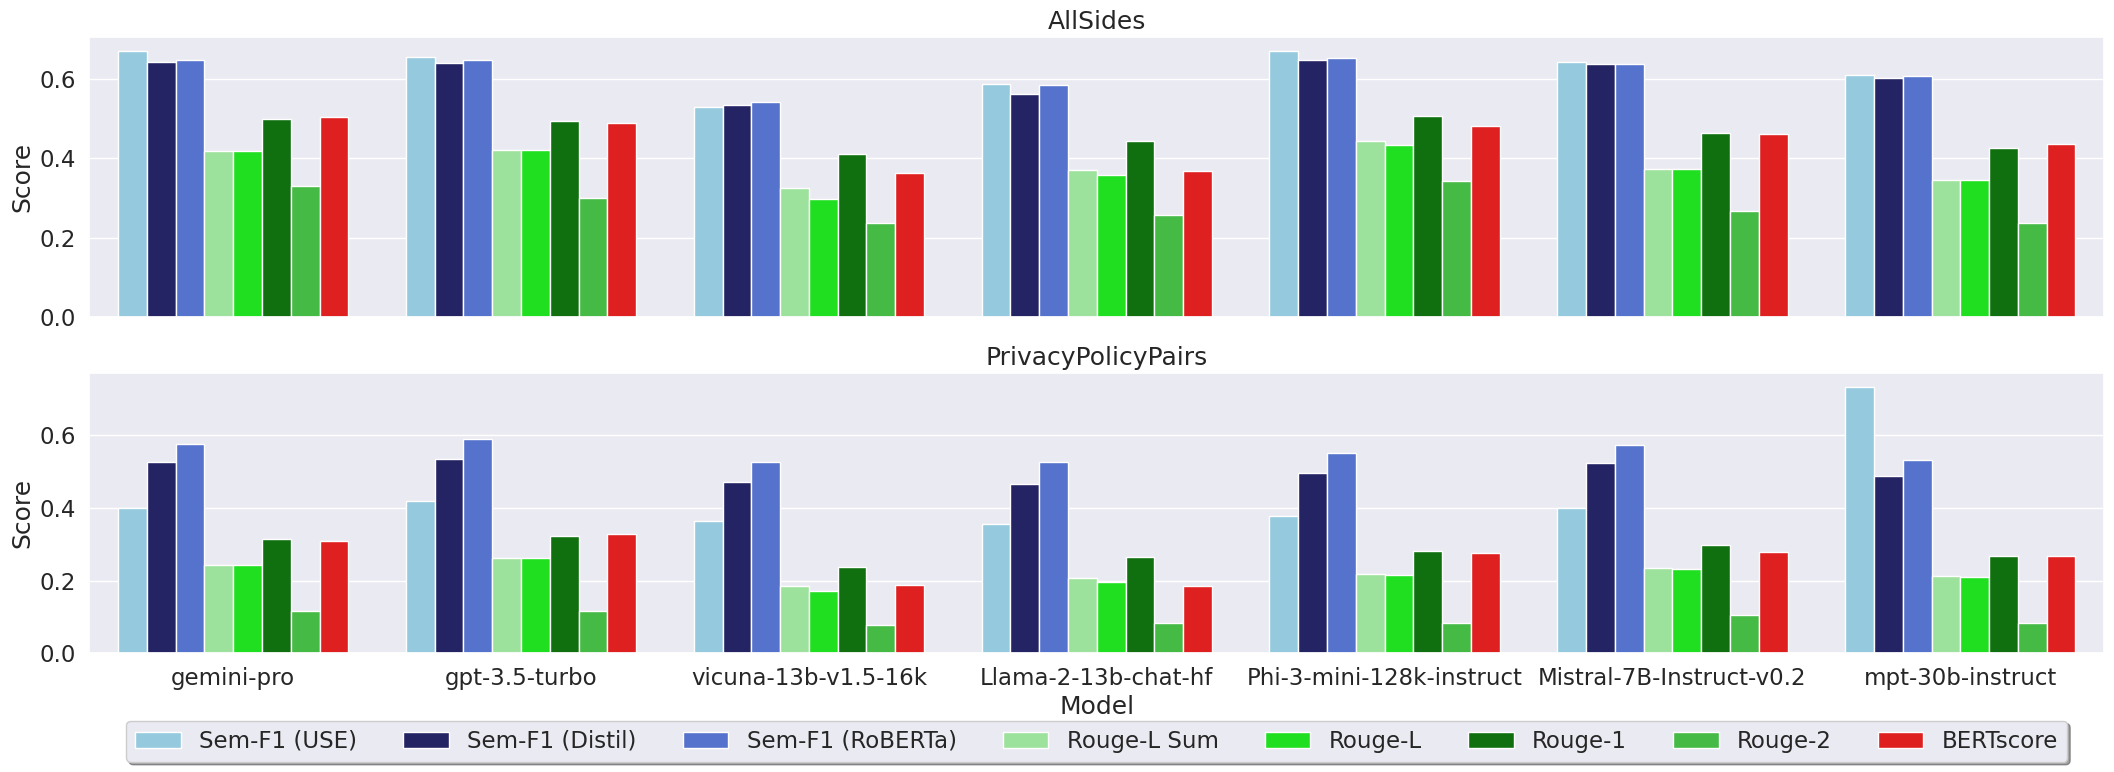

In [62]:
#################################################################################
# get max scores over prompt levels per model for the largest models per family #
#################################################################################
#plt.rcParams.update({'font.size': 56})
color_palette = {
    'BERTscore': 'red',
    'Rouge-1': 'green',
    'Rouge-2': 'limegreen',
    'Rouge-L': 'lime',
    'Rouge-L Sum': 'lightgreen',
    'Sem-F1 (Distil)': 'midnightblue',
    'Sem-F1 (RoBERTa)': 'royalblue',
    'Sem-F1 (USE)': 'skyblue',
}
col_map = {
    'bertscore': 'BERTscore',
    'rouge1': 'Rouge-1',
    'rouge2': 'Rouge-2',
    'rougeL': 'Rouge-L',
    'rougeLsum': 'Rouge-L Sum',
    'semf1-distil': 'Sem-F1 (Distil)',
    'semf1-rob': 'Sem-F1 (RoBERTa)',
    'semf1-use': 'Sem-F1 (USE)',
}
#results_ren = results.rename_columns(col_map)

name_map = {
    'all_sides': 'AllSides',
    'privacy_policy': 'PrivacyPolicyPairs',
}
models = set(ds['model'])

wh = 26.0, 8.0
sns.set_theme(
    rc={'figure.figsize': wh}, 
    font_scale=1.5
)
ds_names = ['all_sides', 'privacy_policy']
max_per_model_data = {name: [] for name in ds_names}
max_per_model_idxs = {name: [] for name in ds_names}
counts_per_tmplt = {
    'l0': 0, 'l1': 0, 'l2': 0,
    'l3': 0, 'l4': 0, 'icl': 0,
}

for name in ds_names:
    #data = results_ren.filter(lambda x: x['dataset'] == name).to_list()
    data = results.filter(lambda x: x['dataset'] == name).to_list()
    for model in sorted(models):
        model_data = list(filter(lambda x: x['model'] == model, data))
        model_ds = Dataset.from_list(model_data)

        #dict_head = {'Model': model, 'Dataset': name}
        dict_head = {'Model': model}
        maxes = {metric: max(model_ds[metric]) for metric in metrics}
        max_indices = {metric: np.argmax(model_ds[metric]) for metric in metrics}

        new_samples = [
            {'Model': model, 'Score': maxes[metric], 'Metric': col_map[metric]} 
            for metric in metrics
        ]
        max_per_model_data[name] += new_samples

        #max_per_model_data[name].append({**dict_head, **maxes})
        # update level counts
        max_per_model_idxs[name].append({**dict_head, **max_indices})

        # TODO put this back in to count prompts
        """
        for metric in metrics:
            counts_per_tmplt[max_per_model_idxs[name][-1][metric]] += 1
        """

# filter out smaller models
keep_models = [
    'gemini-pro',
    'gpt-3.5-turbo',
    'mistralai/Mistral-7B-Instruct-v0.2',
    'lmsys/vicuna-13b-v1.5-16k',
    'mosaicml/mpt-30b-instruct',
    'meta-llama/Llama-2-13b-chat-hf',
    'microsoft/Phi-3-mini-128k-instruct',
]

for dsn, dsl in max_per_model_data.items():
    max_per_model_data[dsn] = list(filter(
        lambda x: x['Model'] in keep_models, 
        dsl
    ))

# truncate from model names
for dsn in max_per_model_data.keys():
    for item in max_per_model_data[dsn]:
        item['Model'] = item['Model'].split('/')[-1]

dataframes = {name: pd.DataFrame(max_per_model_data[name]) for name in ds_names}
"""
for key, val in dataframes.items():
    dataframes[key] = val.rename(columns=col_map)
print(dataframes['all_sides'])
"""

# plot data
fig, ax = plt.subplots(2, 1, sharex=True)
for i, (name, df) in enumerate(dataframes.items()):
    legend = True if i==1 else False
    for j, bar in enumerate(sns.barplot(x='Model',
                                        y='Score',
                                        hue='Metric',
                                        data=df,
                                        ax=ax[i],
                                        legend=legend,
                                        palette=color_palette).patches):
        #bar.set_hatch(hatch_patterns[j // 6])
        pass
    ax[i].set_title(name_map[name])
    ax[1].legend(
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.2), 
        fancybox=True, 
        shadow=True, 
        ncol=8
    )
    #ax[i].tick_params(axis='x', labelrotation=15)

Filter: 100%|██████████| 7072/7072 [00:00<00:00, 144174.23 examples/s]


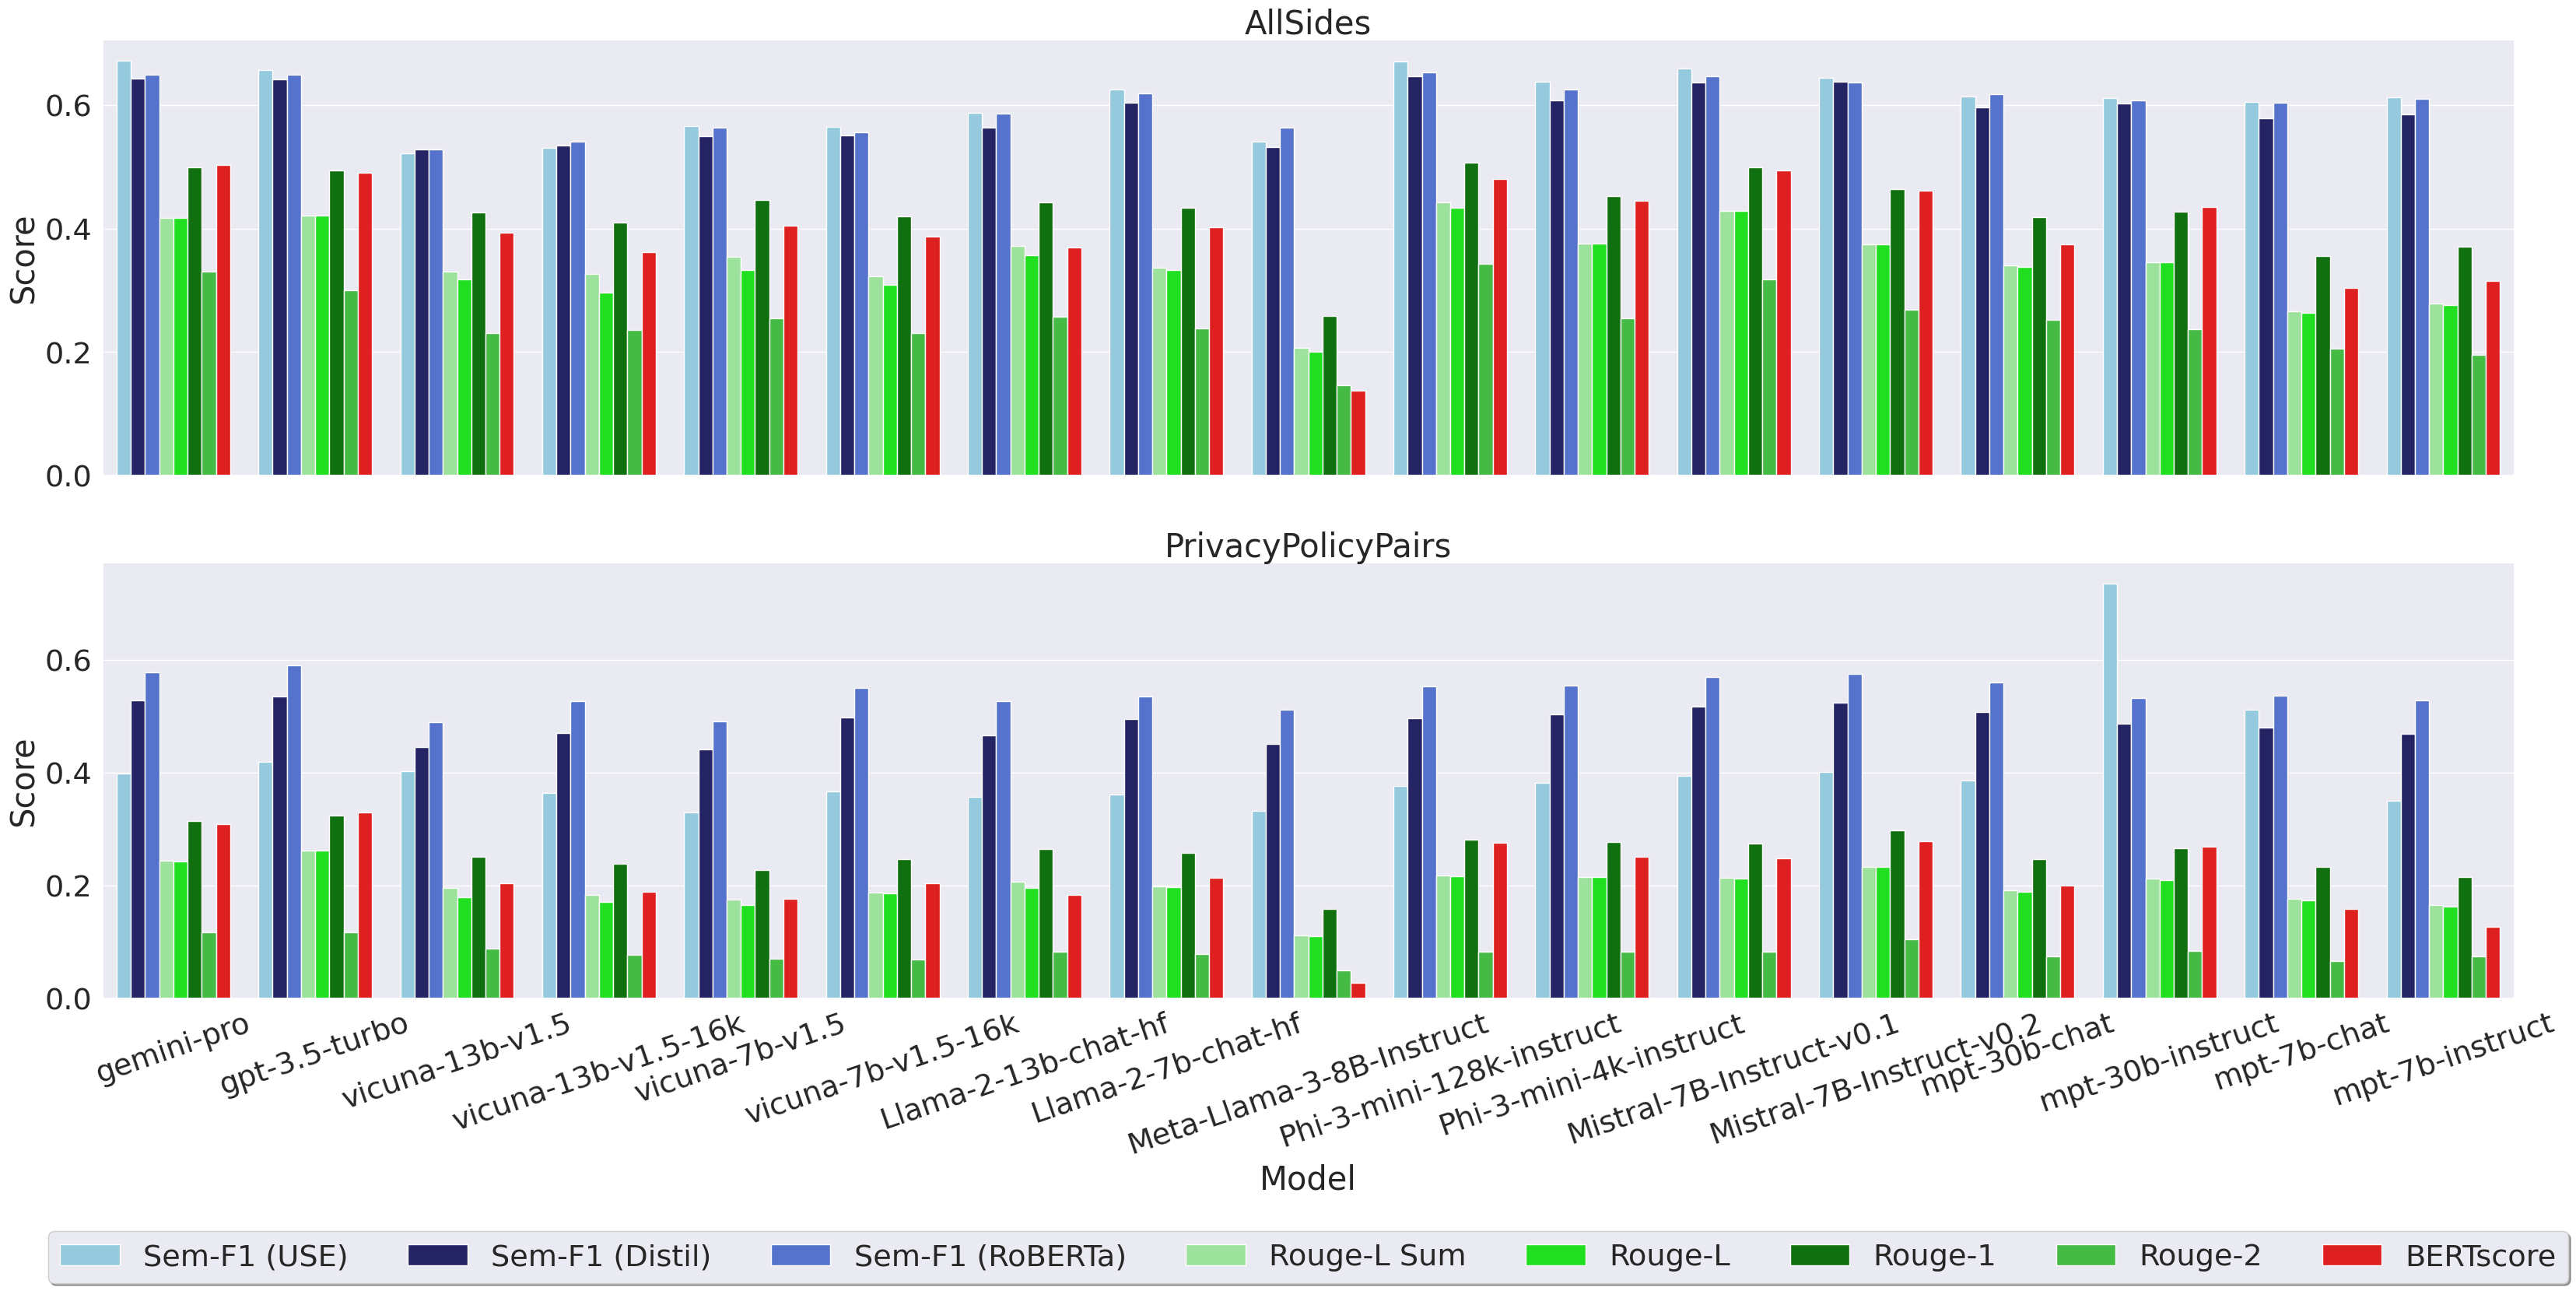

In [124]:

#################################################################################
# get max scores over prompt levels per model for the largest models per family #
#################################################################################
#plt.rcParams.update({'font.size': 56})
color_palette = {
    'BERTscore': 'red',
    'Rouge-1': 'green',
    'Rouge-2': 'limegreen',
    'Rouge-L': 'lime',
    'Rouge-L Sum': 'lightgreen',
    'Sem-F1 (Distil)': 'midnightblue',
    'Sem-F1 (RoBERTa)': 'royalblue',
    'Sem-F1 (USE)': 'skyblue',
}
col_map = {
    'bertscore': 'BERTscore',
    'rouge1': 'Rouge-1',
    'rouge2': 'Rouge-2',
    'rougeL': 'Rouge-L',
    'rougeLsum': 'Rouge-L Sum',
    'semf1-distil': 'Sem-F1 (Distil)',
    'semf1-rob': 'Sem-F1 (RoBERTa)',
    'semf1-use': 'Sem-F1 (USE)',
}
#results_ren = results.rename_columns(col_map)

name_map = {
    'all_sides': 'AllSides',
    'privacy_policy': 'PrivacyPolicyPairs',
}
models = set(ds['model'])

wh = 40.0, 16.0
sns.set_theme(
    rc={'figure.figsize': wh}, 
    font_scale=2.5
)
ds_names = ['all_sides', 'privacy_policy']
max_per_model_data = {name: [] for name in ds_names}
max_per_model_idxs = {name: [] for name in ds_names}
counts_per_tmplt = {
    'l0': 0, 'l1': 0, 'l2': 0,
    'l3': 0, 'l4': 0, 'icl': 0,
}

for name in ds_names:
    data = results.filter(lambda x: x['dataset'] == name).to_list()
    for model in sorted(models):
        model_data = list(filter(lambda x: x['model'] == model, data))
        model_ds = Dataset.from_list(model_data)

        #dict_head = {'Model': model, 'Dataset': name}
        dict_head = {'Model': model}
        maxes = {}

        for metric in metrics:
            model_scores = np.array(model_ds[metric])
            model_scores[model_scores > 1] = 0
            maxes[metric] = np.max(model_scores)
        #maxes = {metric: max(model_ds[metric]) for metric in metrics}
        max_indices = {metric: np.argmax(model_ds[metric]) for metric in metrics}

        new_samples = [
            {'Model': model, 'Score': maxes[metric], 'Metric': col_map[metric]} 
            for metric in metrics
        ]
        max_per_model_data[name] += new_samples

        #max_per_model_data[name].append({**dict_head, **maxes})
        # update level counts
        max_per_model_idxs[name].append({**dict_head, **max_indices})

        # TODO put this back in to count prompts
        """
        for metric in metrics:
            counts_per_tmplt[max_per_model_idxs[name][-1][metric]] += 1
        """

# filter out smaller models
keep_models = [
    'gemini-pro',
    'gpt-3.5-turbo',
    'mistralai/Mistral-7B-Instruct-v0.2',
    'lmsys/vicuna-13b-v1.5-16k',
    'mosaicml/mpt-30b-instruct',
    'meta-llama/Llama-2-13b-chat-hf',
    'microsoft/Phi-3-mini-128k-instruct',
]

"""
for dsn, dsl in max_per_model_data.items():
    max_per_model_data[dsn] = list(filter(
        lambda x: x['Model'] in keep_models, 
        dsl
    ))
"""

# truncate from model names
for dsn in max_per_model_data.keys():
    for item in max_per_model_data[dsn]:
        item['Model'] = item['Model'].split('/')[-1]

dataframes = {name: pd.DataFrame(max_per_model_data[name]) for name in ds_names}
"""
for key, val in dataframes.items():
    dataframes[key] = val.rename(columns=col_map)
print(dataframes['all_sides'])
"""

# plot data
fig, ax = plt.subplots(2, 1, sharex=True)
for i, (name, df) in enumerate(dataframes.items()):
    legend = True if i==1 else False
    for j, bar in enumerate(sns.barplot(x='Model',
                                        y='Score',
                                        hue='Metric',
                                        data=df,
                                        ax=ax[i],
                                        legend=legend,
                                        palette=color_palette).patches):
        #bar.set_hatch(hatch_patterns[j // 6])
        pass
    ax[i].set_title(name_map[name])
ax[1].legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.5), 
    fancybox=True, 
    shadow=True, 
    ncol=8
)
#ax[1].set_xticklabels(labels, rotation=15, ha='right')
ax[1].tick_params(axis='x', labelrotation=19)

In [115]:
templates = sorted(set(ds['template']))
ds_names = ['all_sides', 'privacy_policy']
metrics = [
    'semf1-use', 'semf1-distil', 'semf1-rob',
    'rougeLsum', 'rougeL', 'rouge1', 'rouge2',
    'bertscore',
]
metric_prefs = []
"""
metric_prefs = {
    'all_sides': {t: {} for t in templates},
    'privacy_policy': {t: {} for t in templates},
}
"""

for name, tmplt in product(ds_names, templates):
    filtered_results = results.filter(
        lambda x: x['dataset'] == name and x['template'] == tmplt
    )
    sample = {'dataset': name, 'template': tmplt}

    for metric in metrics:
        #metric_prefs[name][tmplt][metric] = round(np.max(filtered_results[metric]), 3)
        met_sc = np.array(filtered_results[metric], dtype=float)
        met_sc[met_sc > 1] = 0
        sample[metric] = round(np.max(met_sc), 3)
    metric_prefs.append(sample)

print(json.dumps(metric_prefs, indent=4))

Filter: 100%|██████████| 7072/7072 [00:00<00:00, 150762.75 examples/s]


[
    {
        "dataset": "all_sides",
        "template": "icl",
        "semf1-use": 0.651,
        "semf1-distil": 0.621,
        "semf1-rob": 0.639,
        "rougeLsum": 0.367,
        "rougeL": 0.367,
        "rouge1": 0.46,
        "rouge2": 0.267,
        "bertscore": 0.453
    },
    {
        "dataset": "all_sides",
        "template": "l0",
        "semf1-use": 0.614,
        "semf1-distil": 0.6,
        "semf1-rob": 0.618,
        "rougeLsum": 0.315,
        "rougeL": 0.291,
        "rouge1": 0.399,
        "rouge2": 0.209,
        "bertscore": 0.391
    },
    {
        "dataset": "all_sides",
        "template": "l1",
        "semf1-use": 0.671,
        "semf1-distil": 0.646,
        "semf1-rob": 0.652,
        "rougeLsum": 0.442,
        "rougeL": 0.433,
        "rouge1": 0.507,
        "rouge2": 0.342,
        "bertscore": 0.503
    },
    {
        "dataset": "all_sides",
        "template": "l2",
        "semf1-use": 0.653,
        "semf1-distil": 0.631,
        "semf

# Calculate Sem-nCG For All Data

In [10]:
doc_cols = {
    'all_sides': ['Left', 'Right'],
    'privacy_policy': ['Company_1', 'Company_2'],
}
metric = evaluate.load("nbansal/semncg", gpu=4)

preds = ds['response']

# combine source documents
docs = []
#docs = [''.join() ds]
for sample in tqdm(ds, desc='building doc list'):
    name = sample['dataset']
    sample_id = sample['id']
    docs.append(' '.join([ref_data[name][id][col] for col in doc_cols[name]]))
    print(docs[-1])


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [66]:
a = torch.arange(5, device='cuda:3')
print(a+1)

tensor([1, 2, 3, 4, 5], device='cuda:3')


In [52]:
print(ref_data)

{'all_sides': Dataset({
    features: ['Key', 'Left', 'Right', 'Ahmed_Intersection', 'Naman_Intersection', 'Helen_Intersection', 'AllSides_Intersection'],
    num_rows: 137
}), 'privacy_policy': Dataset({
    features: ['Company_1', 'Company_2', 'Category', 'Company_Name_1', 'Company_Name_2', 'Company_Len_1', 'Company_Len_2', 'Annotator1', 'Annotator2', 'Annotator3', 'Unnamed: 10'],
    num_rows: 135
})}


In [60]:
print(ds[-10:]['id'])

[132, 132, 133, 133, 133, 133, 133, 133, 133, 133]
